In [1]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [2]:
import os 
os.chdir('/kaggle/input/data-diff')

In [3]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.

        Parameters:
        - hr_images (list of ndarray): High-resolution images.
        - lr_images (list of ndarray): Low-resolution images.
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = [torch.tensor(img, dtype=torch.float32) for img in hr_images]
        self.lr_images = [torch.tensor(img, dtype=torch.float32) for img in lr_images]
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.

        Parameters:
        - idx (int): Index of the image to retrieve.

        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Ensure LR and HR images are 4D (N, C, H, W) for interpolation
        if len(lr.shape) == 2:  # If single channel 2D image
            lr = lr.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            hr = hr.unsqueeze(0).unsqueeze(0)
        elif len(lr.shape) == 3:  # If 3D (C, H, W) image
            lr = lr.unsqueeze(0)
            hr = hr.unsqueeze(0)
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr, size=hr.shape[2:], mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr.squeeze(0)

In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
def check_for_nans(data_loader):
    for batch_idx, (lr, hr) in enumerate(data_loader):
        if torch.isnan(lr).any():
            print(f"NaN values found in LR images in batch {batch_idx}")
        if torch.isnan(hr).any():
            print(f"NaN values found in HR images in batch {batch_idx}")

check_for_nans(train_loader)

In [7]:
import torch
import numpy as np
import torch.nn.functional as F

def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

T = 1000
betas = linear_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(hr, lr, t, device="cpu"):
    residual = hr - lr
    noise = torch.randn_like(residual)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, residual.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, residual.shape)
    
    noisy_residual = sqrt_alphas_cumprod_t.to(device) * residual.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    
    return noisy_residual, noise.to(device)

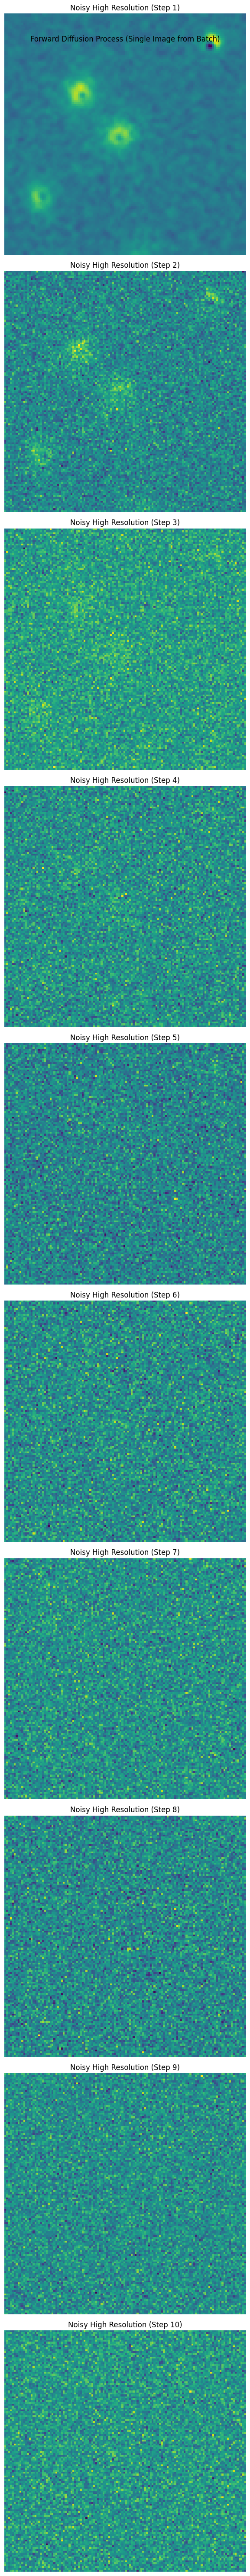

Forward diffusion process completed and visualized for a single image from the batch.


In [8]:
hr, lr = next(iter(train_loader))

image_index = 0  # You can change this to visualize a different image from the batch

# Generate 10 steps of forward diffusion
steps = 10
fig, axs = plt.subplots(steps,1, figsize=(18, 6*steps))
fig.suptitle("Forward Diffusion Process (Single Image from Batch)")

for i in range(steps):
    t = torch.tensor([i * T // steps]).repeat(hr.size(0))
    noisy_residual, _ = forward_diffusion_sample(hr, lr, t)
    
    # Add the noisy residual to the LR image to get the noisy HR image
    noisy_hr = noisy_residual
    
    # Plot the result for the selected image
    lr_img = lr[image_index].squeeze().cpu().numpy()
    hr_img = hr[image_index].squeeze().cpu().numpy()
    noisy_hr_img = noisy_hr[image_index].squeeze().cpu().numpy()
    
    axs[i].imshow(noisy_hr_img, cmap='viridis')
    axs[i].set_title(f'Noisy High Resolution (Step {i+1})')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

print("Forward diffusion process completed and visualized for a single image from the batch.")

In [9]:
import torch
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(...,) + (None,) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 2
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) for i in range(len(down_channels) - 1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleUnet().to(device) 
model.to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [20]:
state_dict_path = '/kaggle/working/resshift_real.pth'
state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, device, epochs=20, T=1000, lr=1e-5):
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    epoch_losses = []
    best_loss = float('inf')
    best_weights = None
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit='batch') as pbar:
            for step, (lr_img, hr_img) in enumerate(train_loader):
                lr_img, hr_img = lr_img.to(device), hr_img.to(device)
                
                optimizer.zero_grad()
                
                timesteps = torch.randint(0, T, (lr_img.size(0),), device=device).long()
                noisy_residual, noise = forward_diffusion_sample(hr_img, lr_img, timesteps, device)
                
                model_input = torch.cat([lr_img, noisy_residual], dim=1)
                
                predicted_residual = model(model_input, timesteps)
                predicted_hr = lr_img + predicted_residual
                
                loss = nn.L1Loss()(predicted_hr, hr_img)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix({'loss': loss.item()})
                pbar.update(1)
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        print(f"End of Epoch {epoch+1} | Avg Loss: {avg_epoch_loss:.8f}")
        
        # Save the best weights
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            best_weights = model.state_dict()
            print(f"New best loss: {best_loss:.8f}")
    
    # Load the best weights back into the model
    model.load_state_dict(best_weights)
    print("Training complete.")
    return epoch_losses

In [28]:
losses = train_model(model, train_loader, device, epochs=50, lr=1e-5)

Epoch 1/50: 100%|██████████| 319/319 [01:05<00:00,  4.88batch/s, loss=0.0117] 


End of Epoch 1 | Avg Loss: 0.01460783
New best loss: 0.01460783


Epoch 2/50: 100%|██████████| 319/319 [01:02<00:00,  5.08batch/s, loss=0.00858]


End of Epoch 2 | Avg Loss: 0.01407956
New best loss: 0.01407956


Epoch 3/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.024]  


End of Epoch 3 | Avg Loss: 0.01408394


Epoch 4/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0158] 


End of Epoch 4 | Avg Loss: 0.01399645
New best loss: 0.01399645


Epoch 5/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0104] 


End of Epoch 5 | Avg Loss: 0.01392198
New best loss: 0.01392198


Epoch 6/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.0113] 


End of Epoch 6 | Avg Loss: 0.01375563
New best loss: 0.01375563


Epoch 7/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.0128] 


End of Epoch 7 | Avg Loss: 0.01371369
New best loss: 0.01371369


Epoch 8/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0208] 


End of Epoch 8 | Avg Loss: 0.01387323


Epoch 9/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0131] 


End of Epoch 9 | Avg Loss: 0.01379026


Epoch 10/50: 100%|██████████| 319/319 [01:02<00:00,  5.08batch/s, loss=0.0168] 


End of Epoch 10 | Avg Loss: 0.01351650
New best loss: 0.01351650


Epoch 11/50: 100%|██████████| 319/319 [01:02<00:00,  5.08batch/s, loss=0.0117] 


End of Epoch 11 | Avg Loss: 0.01371769


Epoch 12/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.012]  


End of Epoch 12 | Avg Loss: 0.01338759
New best loss: 0.01338759


Epoch 13/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.00915]


End of Epoch 13 | Avg Loss: 0.01372801


Epoch 14/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.0159] 


End of Epoch 14 | Avg Loss: 0.01353762


Epoch 15/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.0213] 


End of Epoch 15 | Avg Loss: 0.01332379
New best loss: 0.01332379


Epoch 16/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.00839]


End of Epoch 16 | Avg Loss: 0.01355494


Epoch 17/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.00811]


End of Epoch 17 | Avg Loss: 0.01341908


Epoch 18/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.00906]


End of Epoch 18 | Avg Loss: 0.01342683


Epoch 19/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.00811]


End of Epoch 19 | Avg Loss: 0.01340443


Epoch 20/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0257] 


End of Epoch 20 | Avg Loss: 0.01328995
New best loss: 0.01328995


Epoch 21/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0136] 


End of Epoch 21 | Avg Loss: 0.01328416
New best loss: 0.01328416


Epoch 22/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.015]  


End of Epoch 22 | Avg Loss: 0.01350311


Epoch 23/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.0113] 


End of Epoch 23 | Avg Loss: 0.01335066


Epoch 24/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0141] 


End of Epoch 24 | Avg Loss: 0.01317084
New best loss: 0.01317084


Epoch 25/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.00977]


End of Epoch 25 | Avg Loss: 0.01314261
New best loss: 0.01314261


Epoch 26/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0221] 


End of Epoch 26 | Avg Loss: 0.01313999
New best loss: 0.01313999


Epoch 27/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.0188] 


End of Epoch 27 | Avg Loss: 0.01312798
New best loss: 0.01312798


Epoch 28/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0159] 


End of Epoch 28 | Avg Loss: 0.01310246
New best loss: 0.01310246


Epoch 29/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.00543]


End of Epoch 29 | Avg Loss: 0.01322001


Epoch 30/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0106] 


End of Epoch 30 | Avg Loss: 0.01310349


Epoch 31/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0115] 


End of Epoch 31 | Avg Loss: 0.01290819
New best loss: 0.01290819


Epoch 32/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.00836]


End of Epoch 32 | Avg Loss: 0.01305262


Epoch 33/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0125] 


End of Epoch 33 | Avg Loss: 0.01319382


Epoch 34/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0108] 


End of Epoch 34 | Avg Loss: 0.01305331


Epoch 35/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.036]  


End of Epoch 35 | Avg Loss: 0.01312635


Epoch 36/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.0093] 


End of Epoch 36 | Avg Loss: 0.01301980


Epoch 37/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.00866]


End of Epoch 37 | Avg Loss: 0.01295392


Epoch 38/50: 100%|██████████| 319/319 [01:03<00:00,  5.03batch/s, loss=0.0126] 


End of Epoch 38 | Avg Loss: 0.01287735
New best loss: 0.01287735


Epoch 39/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.00897]


End of Epoch 39 | Avg Loss: 0.01297587


Epoch 40/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.00687]


End of Epoch 40 | Avg Loss: 0.01281614
New best loss: 0.01281614


Epoch 41/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.00872]


End of Epoch 41 | Avg Loss: 0.01288402


Epoch 42/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0113] 


End of Epoch 42 | Avg Loss: 0.01274153
New best loss: 0.01274153


Epoch 43/50: 100%|██████████| 319/319 [01:03<00:00,  5.04batch/s, loss=0.00735]


End of Epoch 43 | Avg Loss: 0.01303526


Epoch 44/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.0112] 


End of Epoch 44 | Avg Loss: 0.01294120


Epoch 45/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.0132] 


End of Epoch 45 | Avg Loss: 0.01292267


Epoch 46/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0139] 


End of Epoch 46 | Avg Loss: 0.01308216


Epoch 47/50: 100%|██████████| 319/319 [01:03<00:00,  5.04batch/s, loss=0.0111] 


End of Epoch 47 | Avg Loss: 0.01287652


Epoch 48/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.0105] 


End of Epoch 48 | Avg Loss: 0.01268609
New best loss: 0.01268609


Epoch 49/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0134] 


End of Epoch 49 | Avg Loss: 0.01281056


Epoch 50/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.0151] 

End of Epoch 50 | Avg Loss: 0.01270393
Training complete.


In [16]:
losses = train_model(model, train_loader, device, epochs=50, lr=1e-6)

Epoch 1/50: 100%|██████████| 319/319 [01:03<00:00,  5.01batch/s, loss=0.00904]


End of Epoch 1 | Avg Loss: 0.01391249
New best loss: 0.01391249


Epoch 2/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.0252] 


End of Epoch 2 | Avg Loss: 0.01370018
New best loss: 0.01370018


Epoch 3/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.016]  


End of Epoch 3 | Avg Loss: 0.01382509


Epoch 4/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0137] 


End of Epoch 4 | Avg Loss: 0.01355539
New best loss: 0.01355539


Epoch 5/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.00913]


End of Epoch 5 | Avg Loss: 0.01368029


Epoch 6/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0148] 


End of Epoch 6 | Avg Loss: 0.01357338


Epoch 7/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0135] 


End of Epoch 7 | Avg Loss: 0.01364427


Epoch 8/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.00948]


End of Epoch 8 | Avg Loss: 0.01352317
New best loss: 0.01352317


Epoch 9/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0128] 


End of Epoch 9 | Avg Loss: 0.01373572


Epoch 10/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.049]  


End of Epoch 10 | Avg Loss: 0.01378654


Epoch 11/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.011]  


End of Epoch 11 | Avg Loss: 0.01378246


Epoch 12/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0081] 


End of Epoch 12 | Avg Loss: 0.01381999


Epoch 13/50: 100%|██████████| 319/319 [01:02<00:00,  5.08batch/s, loss=0.0152] 


End of Epoch 13 | Avg Loss: 0.01372583


Epoch 14/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.023]  


End of Epoch 14 | Avg Loss: 0.01364006


Epoch 15/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0154] 


End of Epoch 15 | Avg Loss: 0.01338721
New best loss: 0.01338721


Epoch 16/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.0169] 


End of Epoch 16 | Avg Loss: 0.01352322


Epoch 17/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0324] 


End of Epoch 17 | Avg Loss: 0.01335513
New best loss: 0.01335513


Epoch 18/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0131] 


End of Epoch 18 | Avg Loss: 0.01323694
New best loss: 0.01323694


Epoch 19/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.00837]


End of Epoch 19 | Avg Loss: 0.01364707


Epoch 20/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.00838]


End of Epoch 20 | Avg Loss: 0.01351936


Epoch 21/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0121] 


End of Epoch 21 | Avg Loss: 0.01339542


Epoch 22/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0176] 


End of Epoch 22 | Avg Loss: 0.01338425


Epoch 23/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0153] 


End of Epoch 23 | Avg Loss: 0.01326211


Epoch 24/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0164] 


End of Epoch 24 | Avg Loss: 0.01331047


Epoch 25/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0122] 


End of Epoch 25 | Avg Loss: 0.01356220


Epoch 26/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.00848]


End of Epoch 26 | Avg Loss: 0.01395044


Epoch 27/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0115] 


End of Epoch 27 | Avg Loss: 0.01369952


Epoch 28/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0175] 


End of Epoch 28 | Avg Loss: 0.01336146


Epoch 29/50: 100%|██████████| 319/319 [01:02<00:00,  5.08batch/s, loss=0.00924]


End of Epoch 29 | Avg Loss: 0.01354220


Epoch 30/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.00606]


End of Epoch 30 | Avg Loss: 0.01320042
New best loss: 0.01320042


Epoch 31/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0153] 


End of Epoch 31 | Avg Loss: 0.01309488
New best loss: 0.01309488


Epoch 32/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0149] 


End of Epoch 32 | Avg Loss: 0.01318094


Epoch 33/50: 100%|██████████| 319/319 [01:02<00:00,  5.06batch/s, loss=0.00757]


End of Epoch 33 | Avg Loss: 0.01336371


Epoch 34/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.00829]


End of Epoch 34 | Avg Loss: 0.01365328


Epoch 35/50: 100%|██████████| 319/319 [01:02<00:00,  5.08batch/s, loss=0.026]  


End of Epoch 35 | Avg Loss: 0.01347612


Epoch 36/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0191] 


End of Epoch 36 | Avg Loss: 0.01311836


Epoch 37/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0242] 


End of Epoch 37 | Avg Loss: 0.01338937


Epoch 38/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0116] 


End of Epoch 38 | Avg Loss: 0.01321737


Epoch 39/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0116] 


End of Epoch 39 | Avg Loss: 0.01337910


Epoch 40/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.012]  


End of Epoch 40 | Avg Loss: 0.01328449


Epoch 41/50: 100%|██████████| 319/319 [01:03<00:00,  5.05batch/s, loss=0.0153] 


End of Epoch 41 | Avg Loss: 0.01325067


Epoch 42/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0158] 


End of Epoch 42 | Avg Loss: 0.01343015


Epoch 43/50: 100%|██████████| 319/319 [01:02<00:00,  5.08batch/s, loss=0.00875]


End of Epoch 43 | Avg Loss: 0.01309081
New best loss: 0.01309081


Epoch 44/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0467] 


End of Epoch 44 | Avg Loss: 0.01316080


Epoch 45/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.02]   


End of Epoch 45 | Avg Loss: 0.01318715


Epoch 46/50: 100%|██████████| 319/319 [01:03<00:00,  5.06batch/s, loss=0.0138] 


End of Epoch 46 | Avg Loss: 0.01319319


Epoch 47/50: 100%|██████████| 319/319 [01:02<00:00,  5.08batch/s, loss=0.0198] 


End of Epoch 47 | Avg Loss: 0.01331216


Epoch 48/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0125] 


End of Epoch 48 | Avg Loss: 0.01345885


Epoch 49/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0121] 


End of Epoch 49 | Avg Loss: 0.01336397


Epoch 50/50: 100%|██████████| 319/319 [01:02<00:00,  5.07batch/s, loss=0.0121] 

End of Epoch 50 | Avg Loss: 0.01323531
Training complete.


In [18]:
torch.save(model.state_dict(), '/kaggle/working/resshift_real.pth') 

In [21]:
import torch
import numpy as np
from torch import nn
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def calculate_ssim(img1, img2, data_range=1.0, win_size=11):
    img1 = img1.squeeze().cpu().numpy()
    img2 = img2.squeeze().cpu().numpy()
    return structural_similarity(img1, img2, win_size=win_size, data_range=data_range, multichannel=False)

def evaluate_model(model, dataloader, device, win_size=11, data_range=1.0):
    model.eval()
    mse_hr_predhr = 0.0
    psnr_hr_predhr = 0.0
    ssim_hr_predhr = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for lr_batch, hr_batch in tqdm(dataloader, desc="Evaluating"):
            lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
            batch_size = lr_batch.size(0)
            
            for i in range(batch_size):
                lr, hr = lr_batch[i].unsqueeze(0), hr_batch[i].unsqueeze(0)
                
                # Generate random noisy residual
                random_residual = torch.randn_like(lr)
                
                # Concatenate LR and random residual
                model_input = torch.cat([lr, random_residual], dim=1)
                
                # Set timestep to 1000 for starting from random noise
                timesteps = torch.tensor([1000], device=device).long()
                
                predicted_residual = model(model_input, timesteps)
                predicted_hr = lr + predicted_residual
                
                mse_hr_predhr += nn.MSELoss()(hr, predicted_hr).item()
                psnr_hr_predhr += calculate_psnr(hr, predicted_hr).item()
                ssim_hr_predhr += calculate_ssim(hr, predicted_hr, data_range, win_size)
                
                num_samples += 1
    
    mse_hr_predhr /= num_samples
    psnr_hr_predhr /= num_samples
    ssim_hr_predhr /= num_samples
    
    print(f"Avg MSE (HR, Predicted HR): {mse_hr_predhr:.8f}")
    print(f"Avg PSNR (HR, Predicted HR): {psnr_hr_predhr:.8f}")
    print(f"Avg SSIM (HR, Predicted HR): {ssim_hr_predhr:.8f}")

evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]

Avg MSE (HR, Predicted HR): 0.00073921
Avg PSNR (HR, Predicted HR): 33.56625000
Avg SSIM (HR, Predicted HR): 0.85596071


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

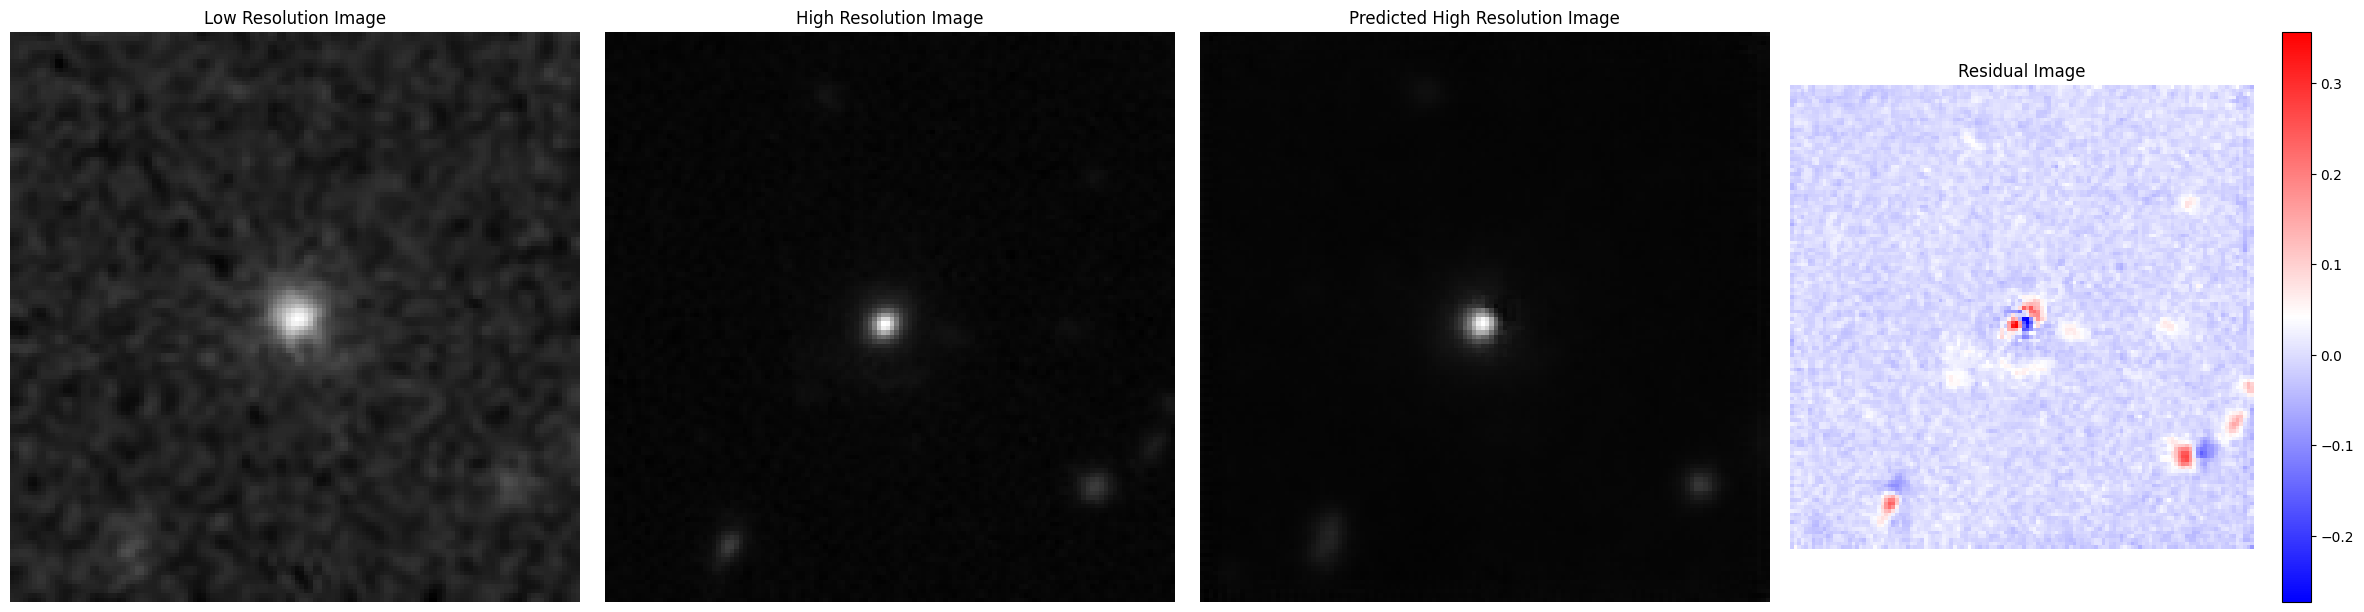

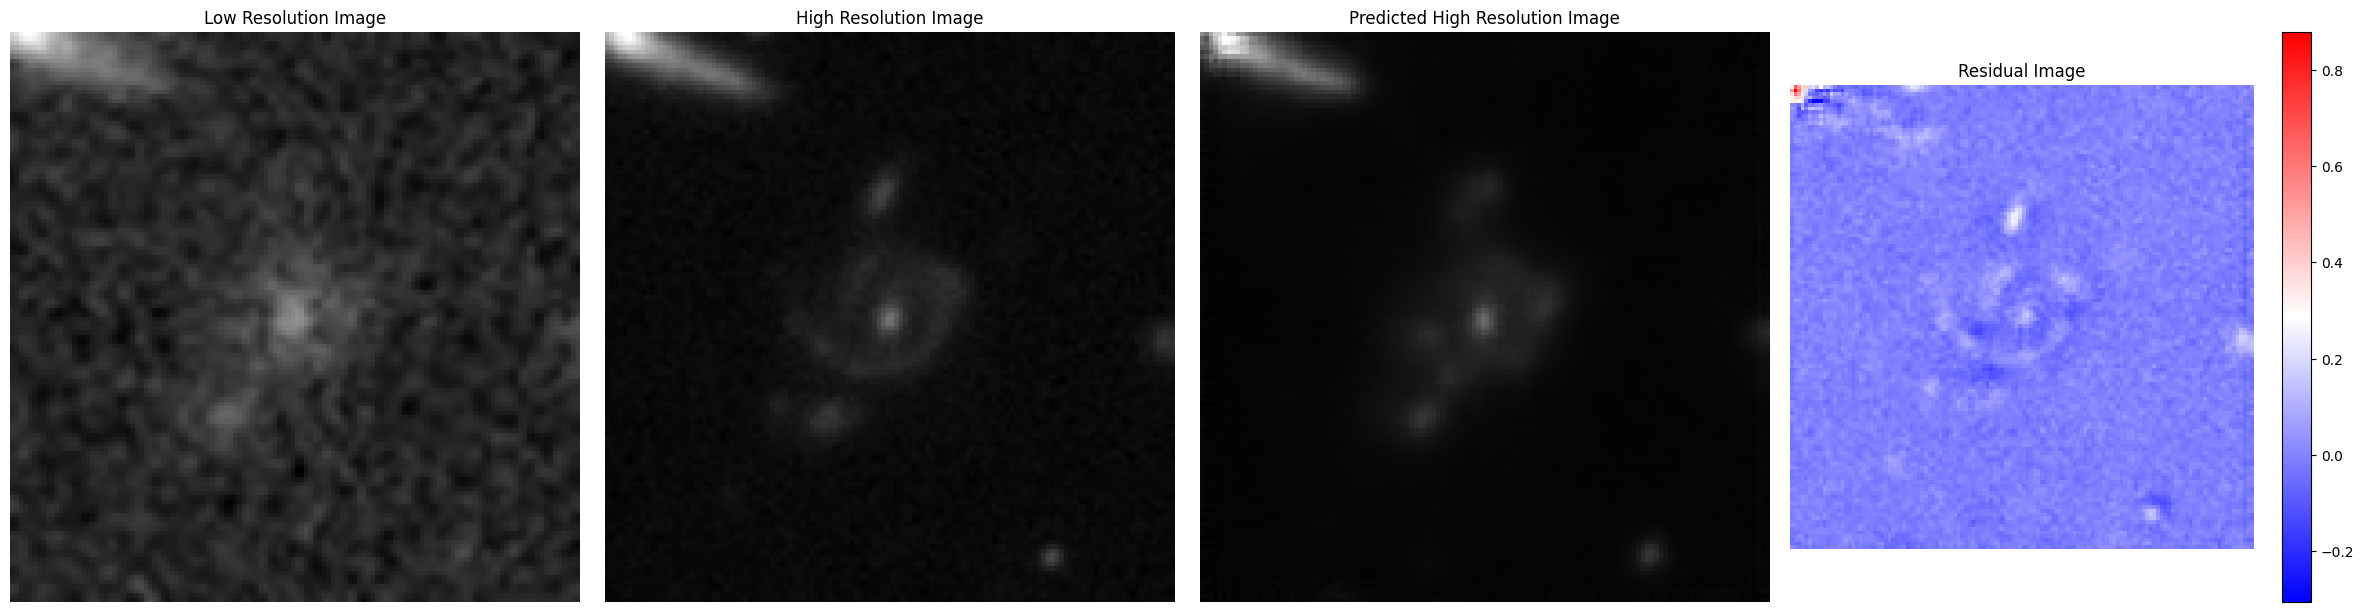

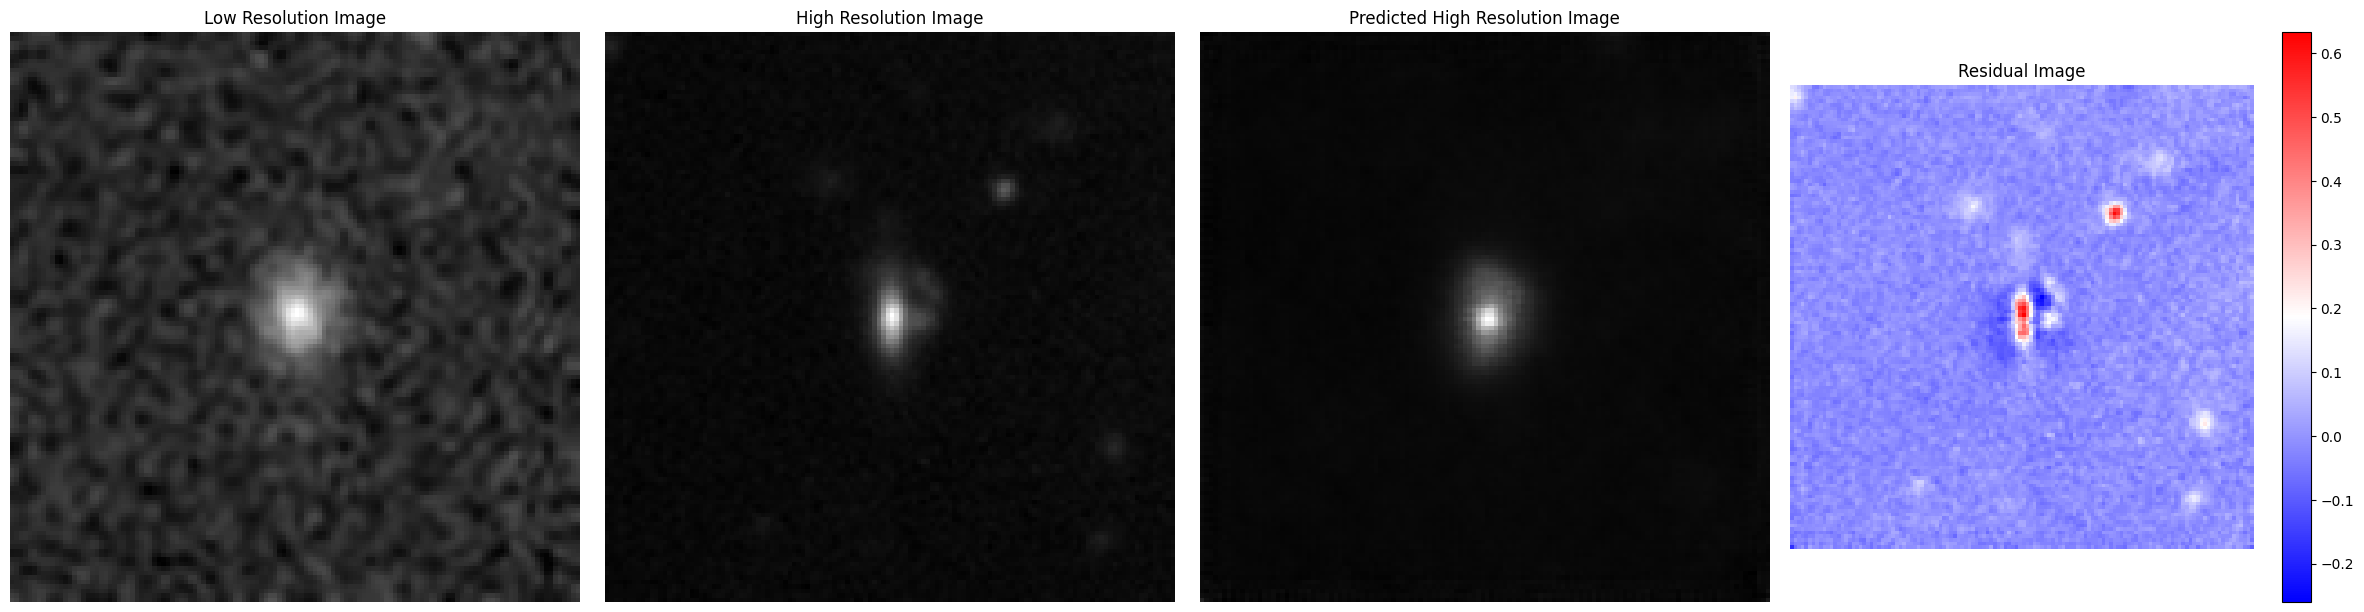

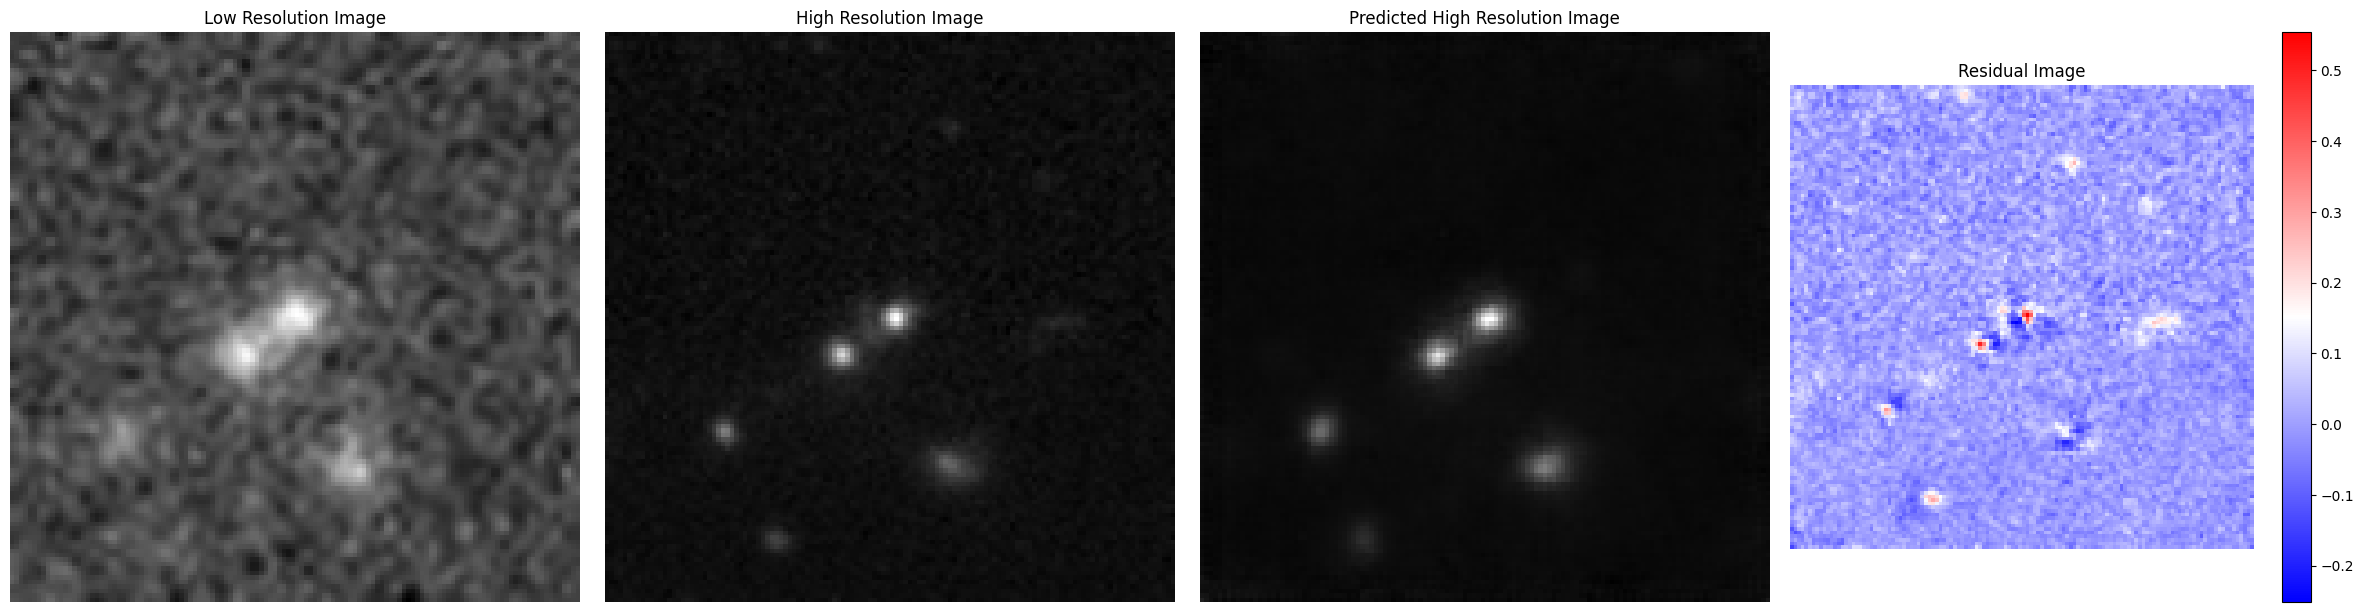

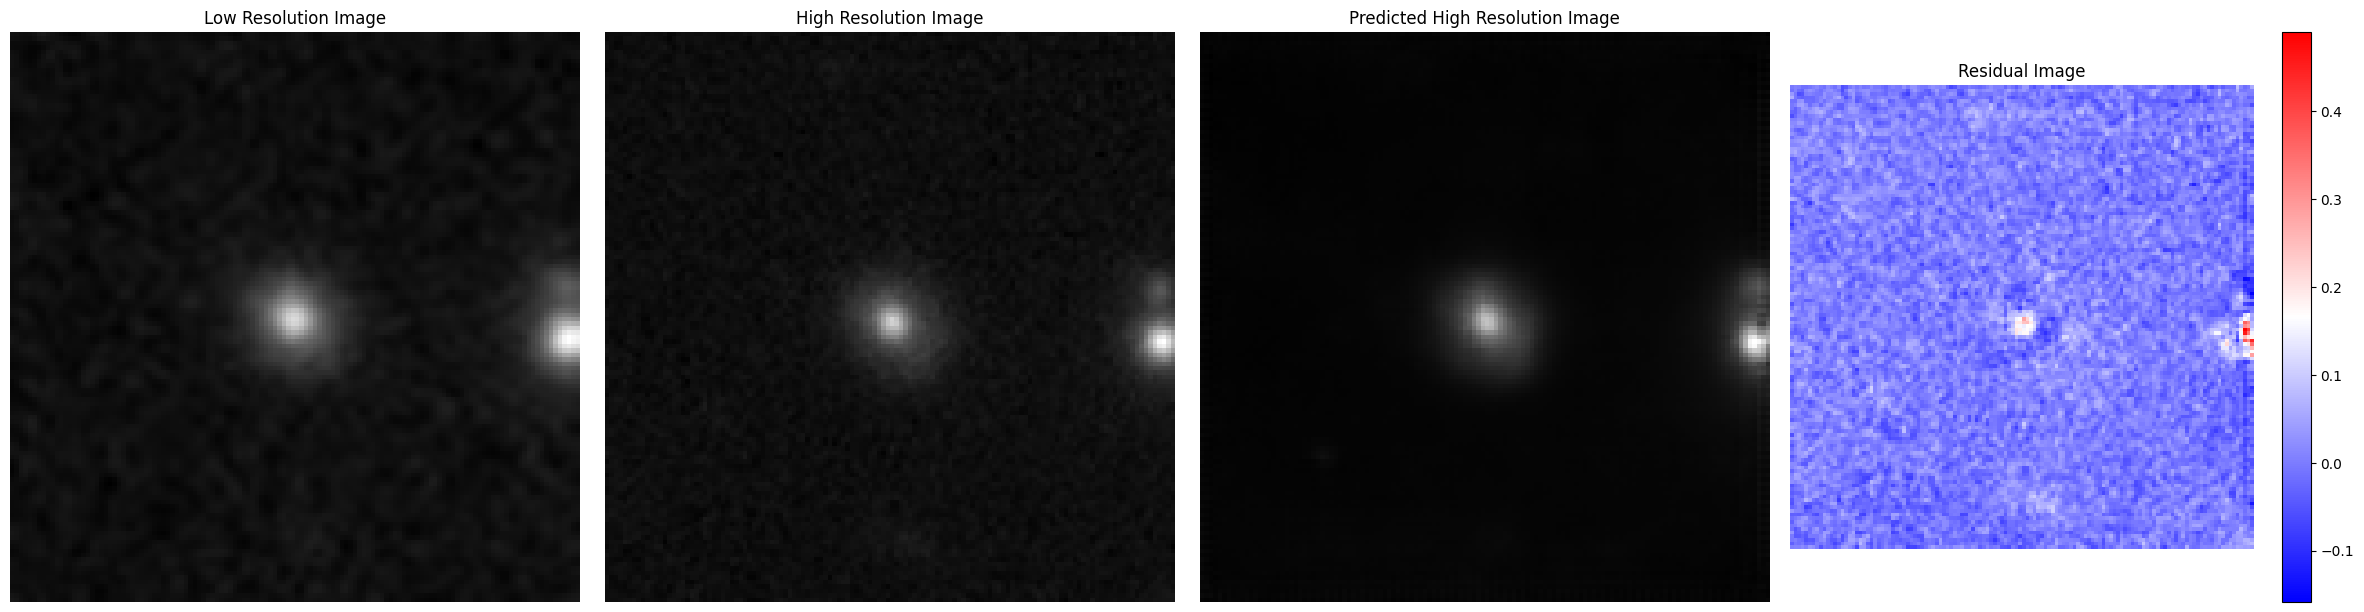

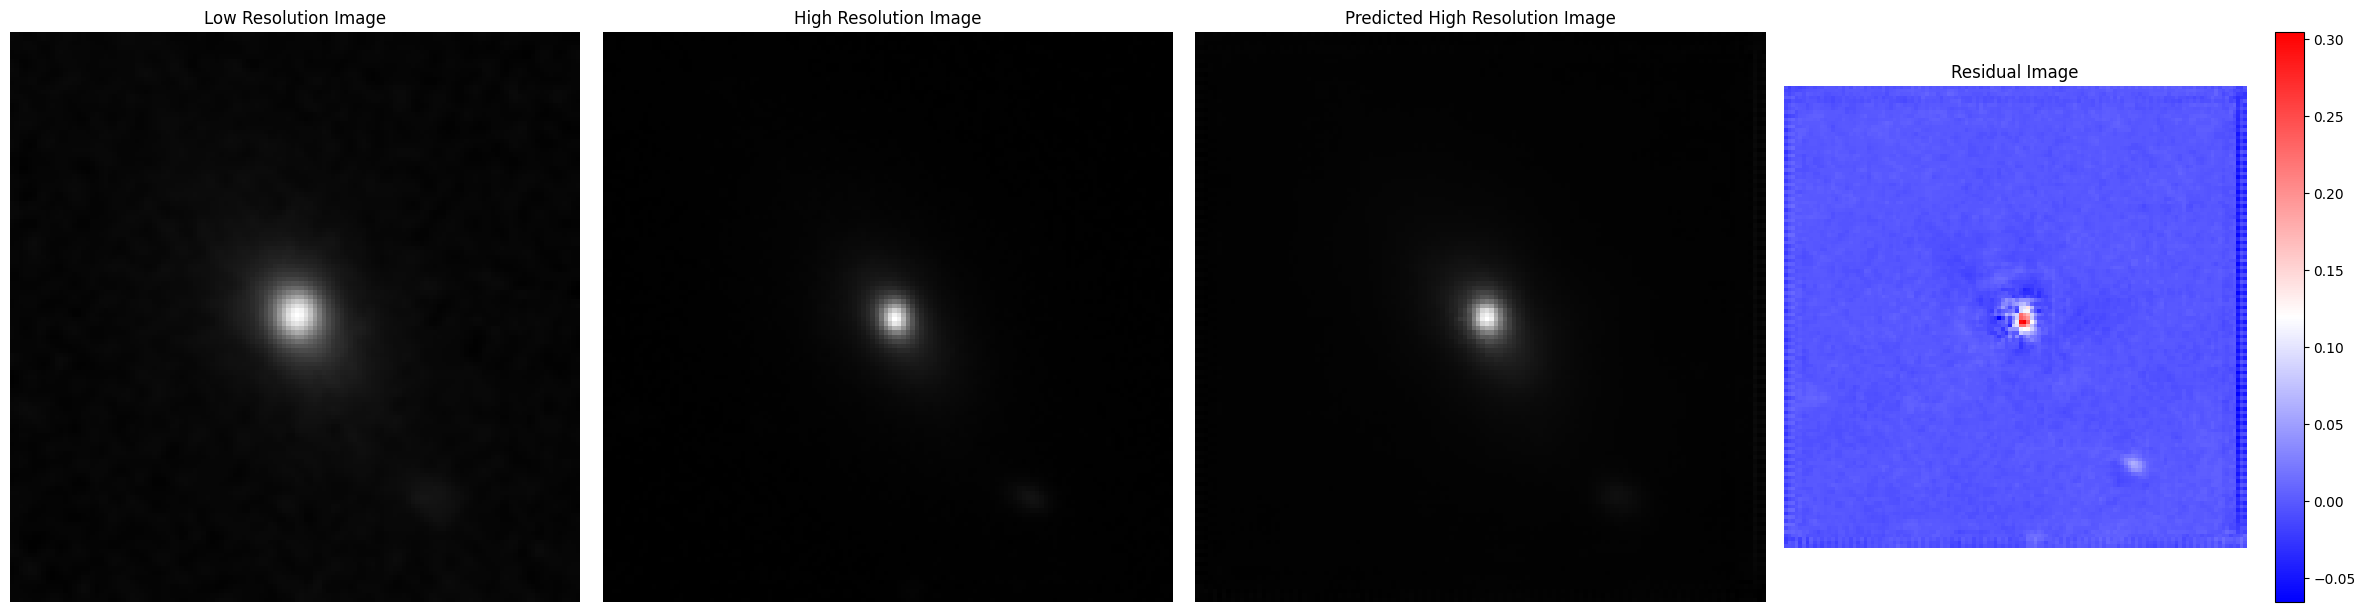

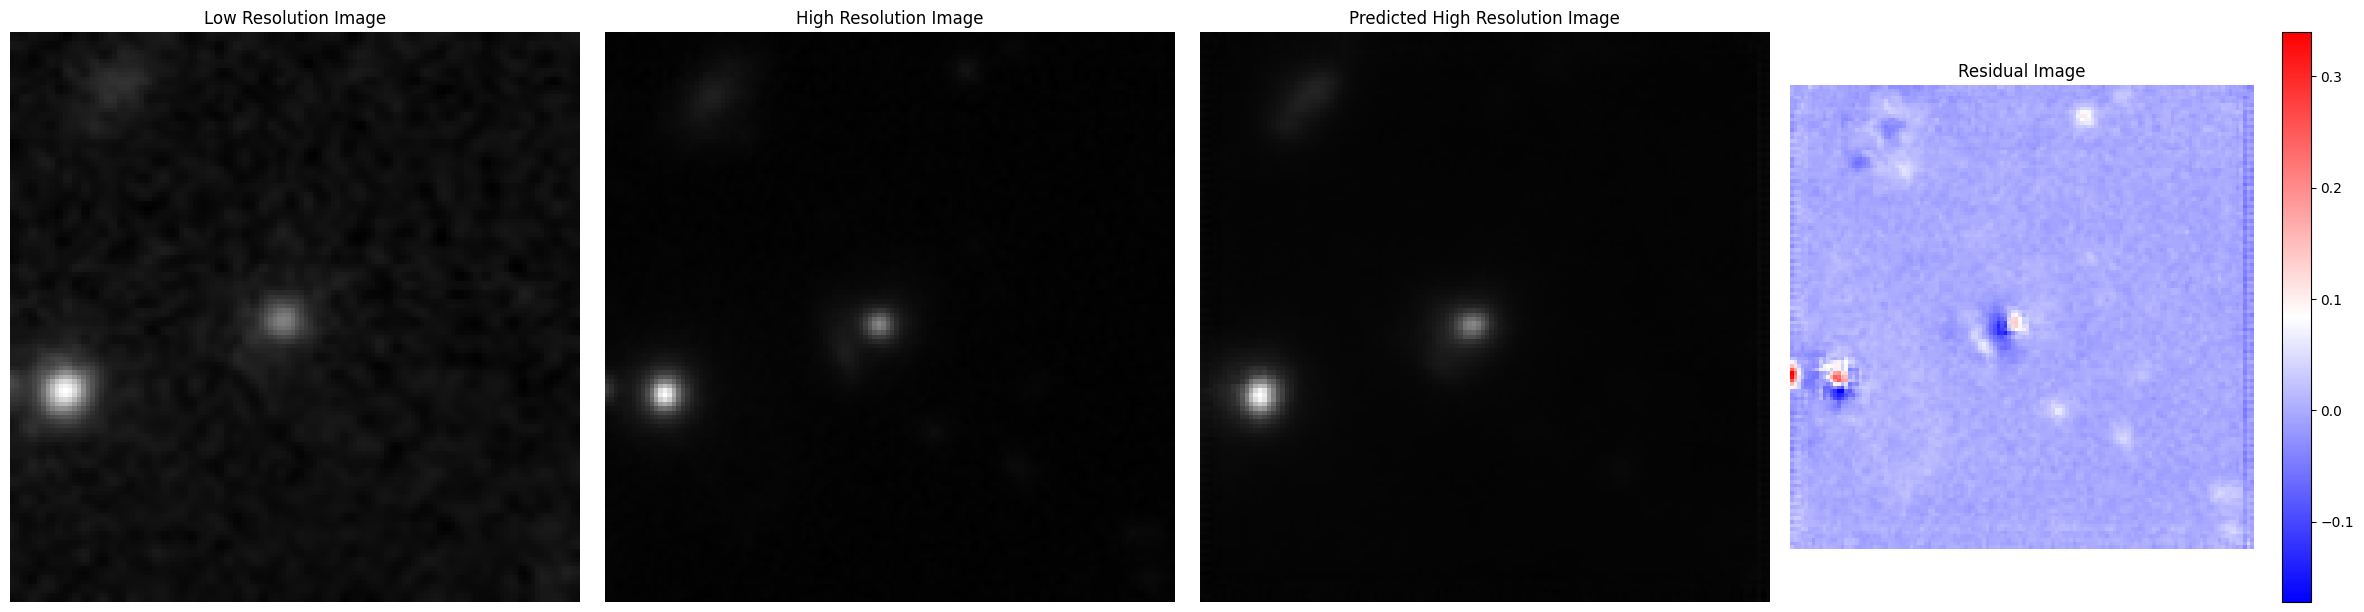

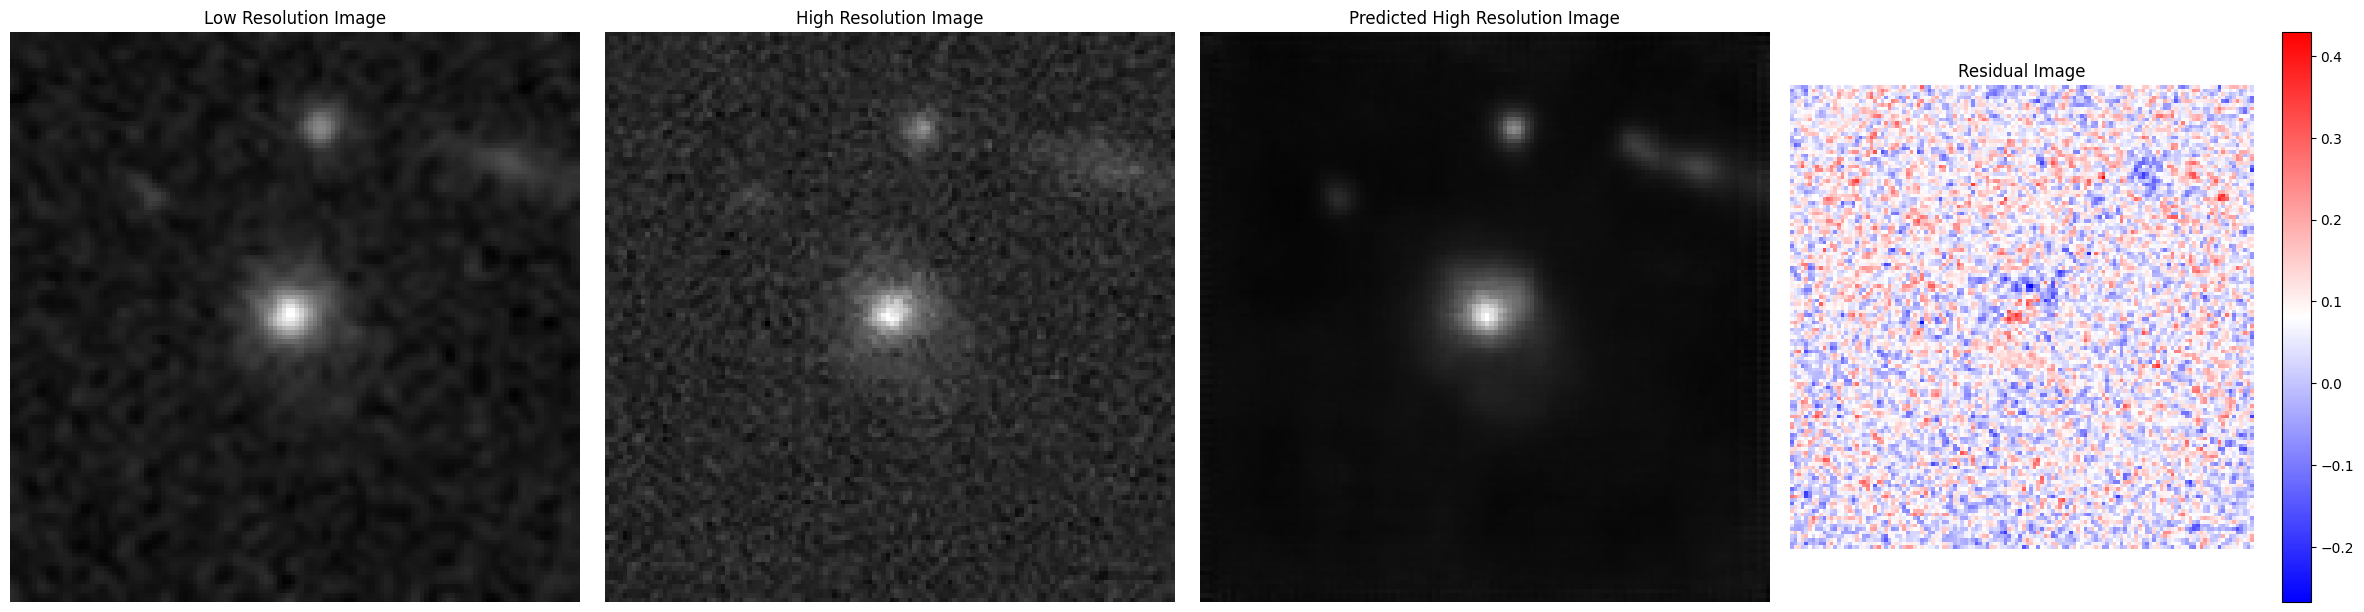

Evaluating:   3%|▎         | 1/36 [00:05<03:01,  5.19s/it]

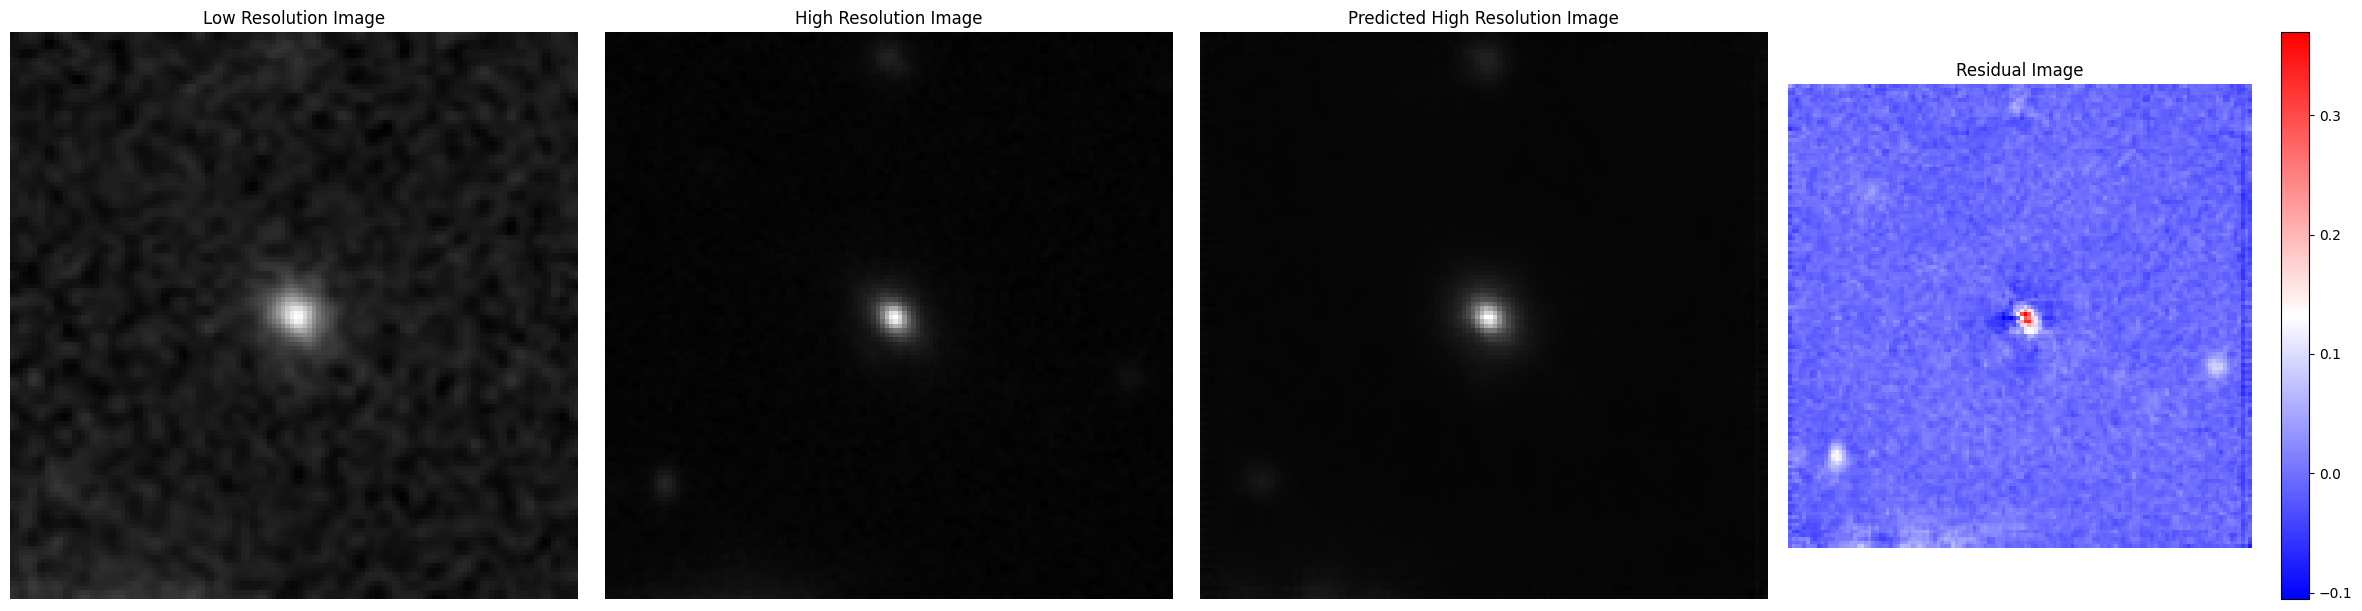

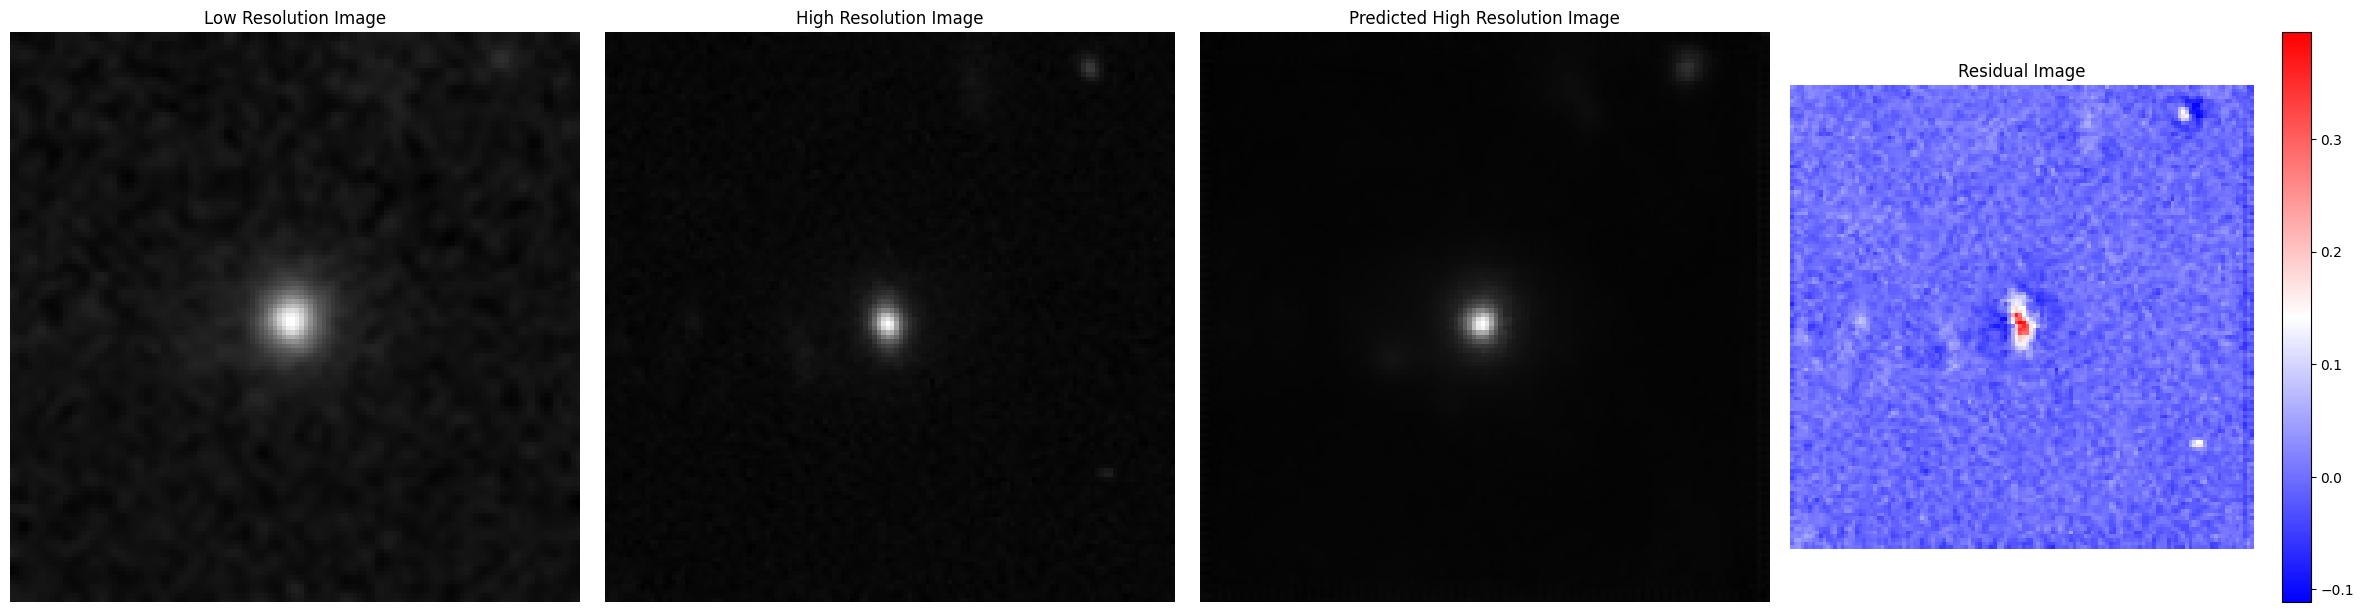

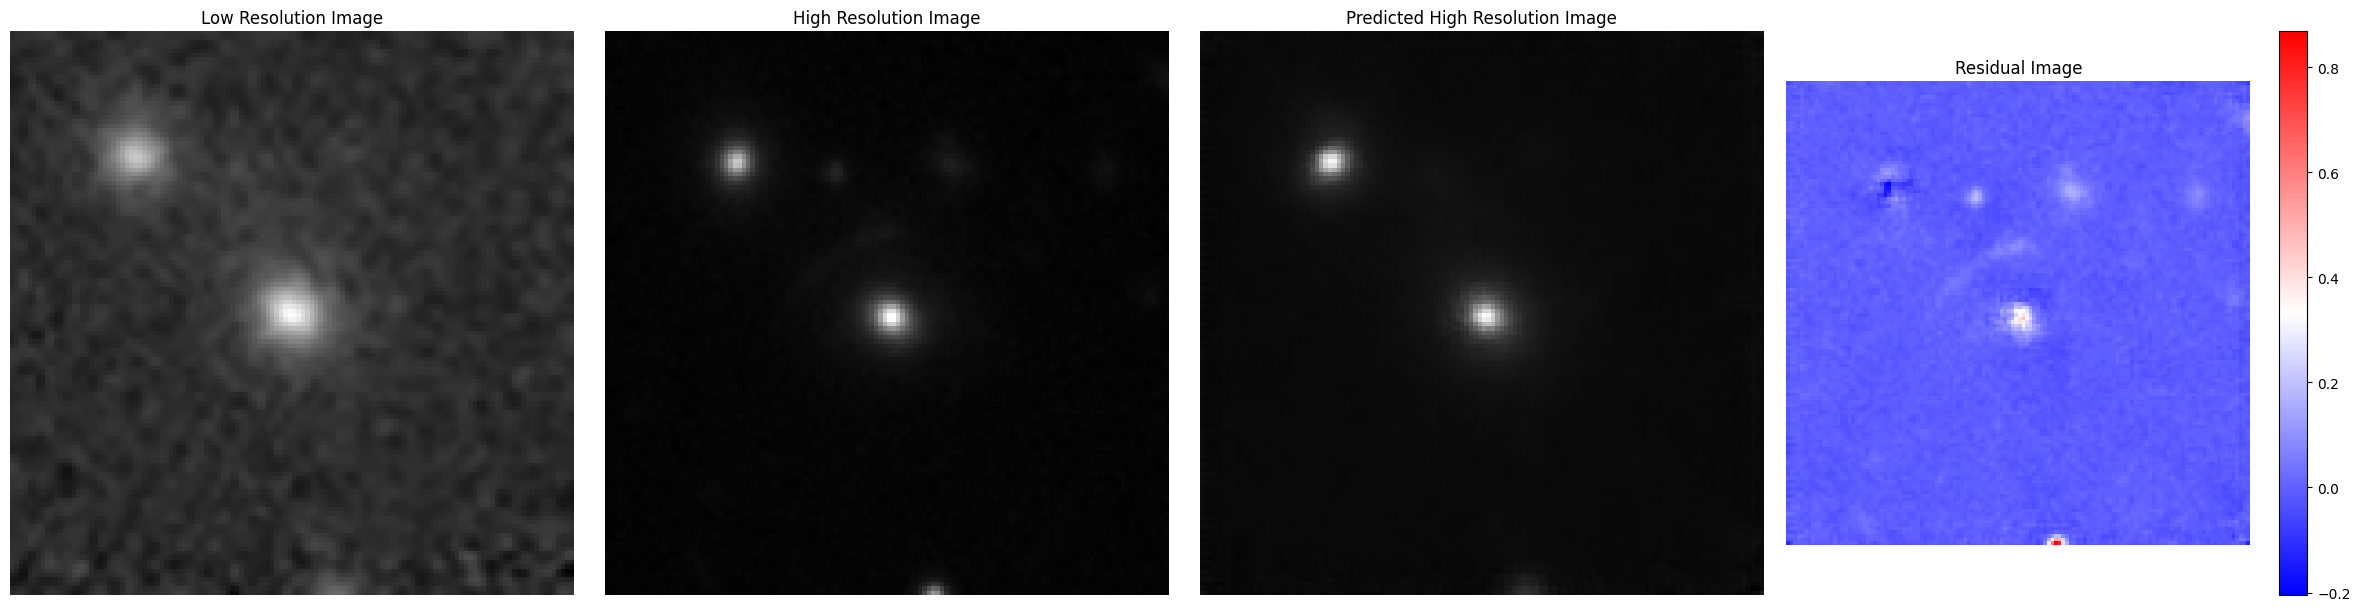

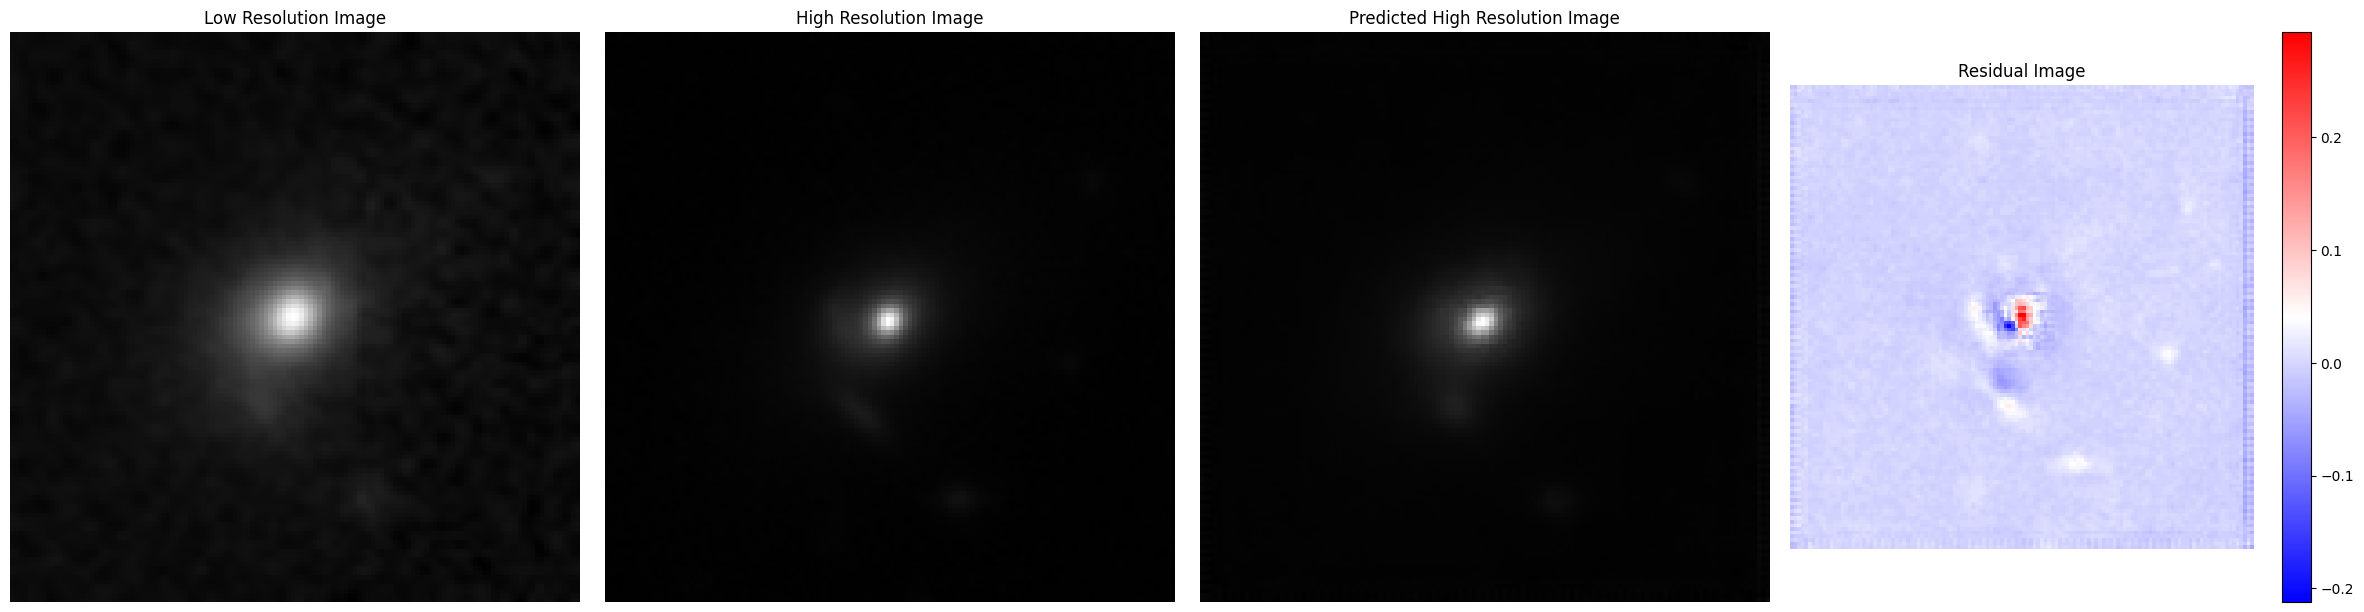

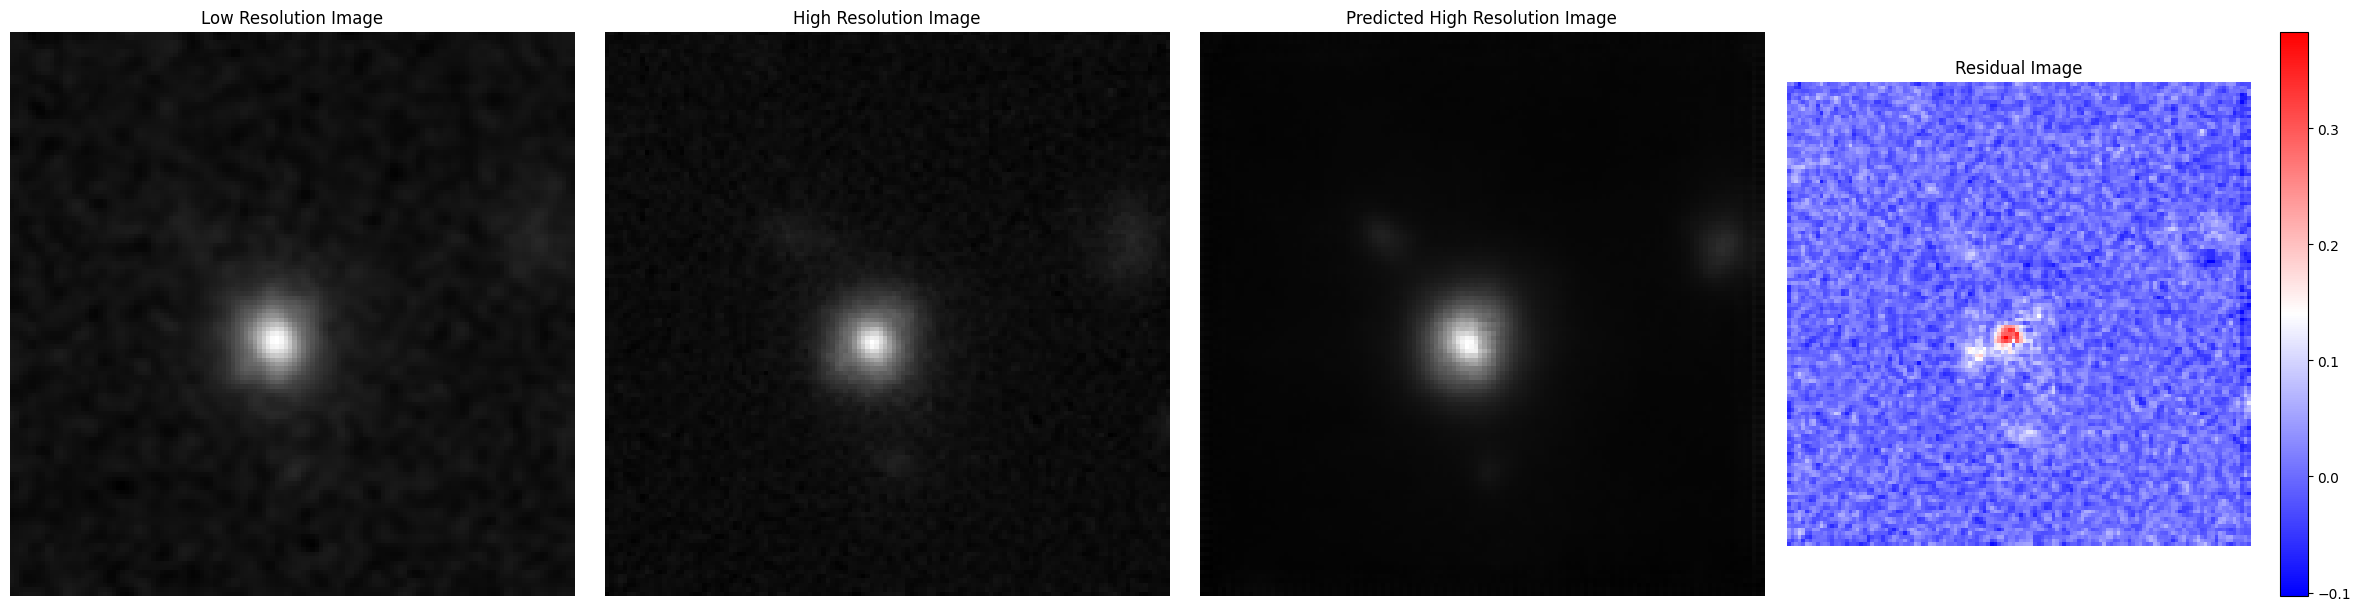

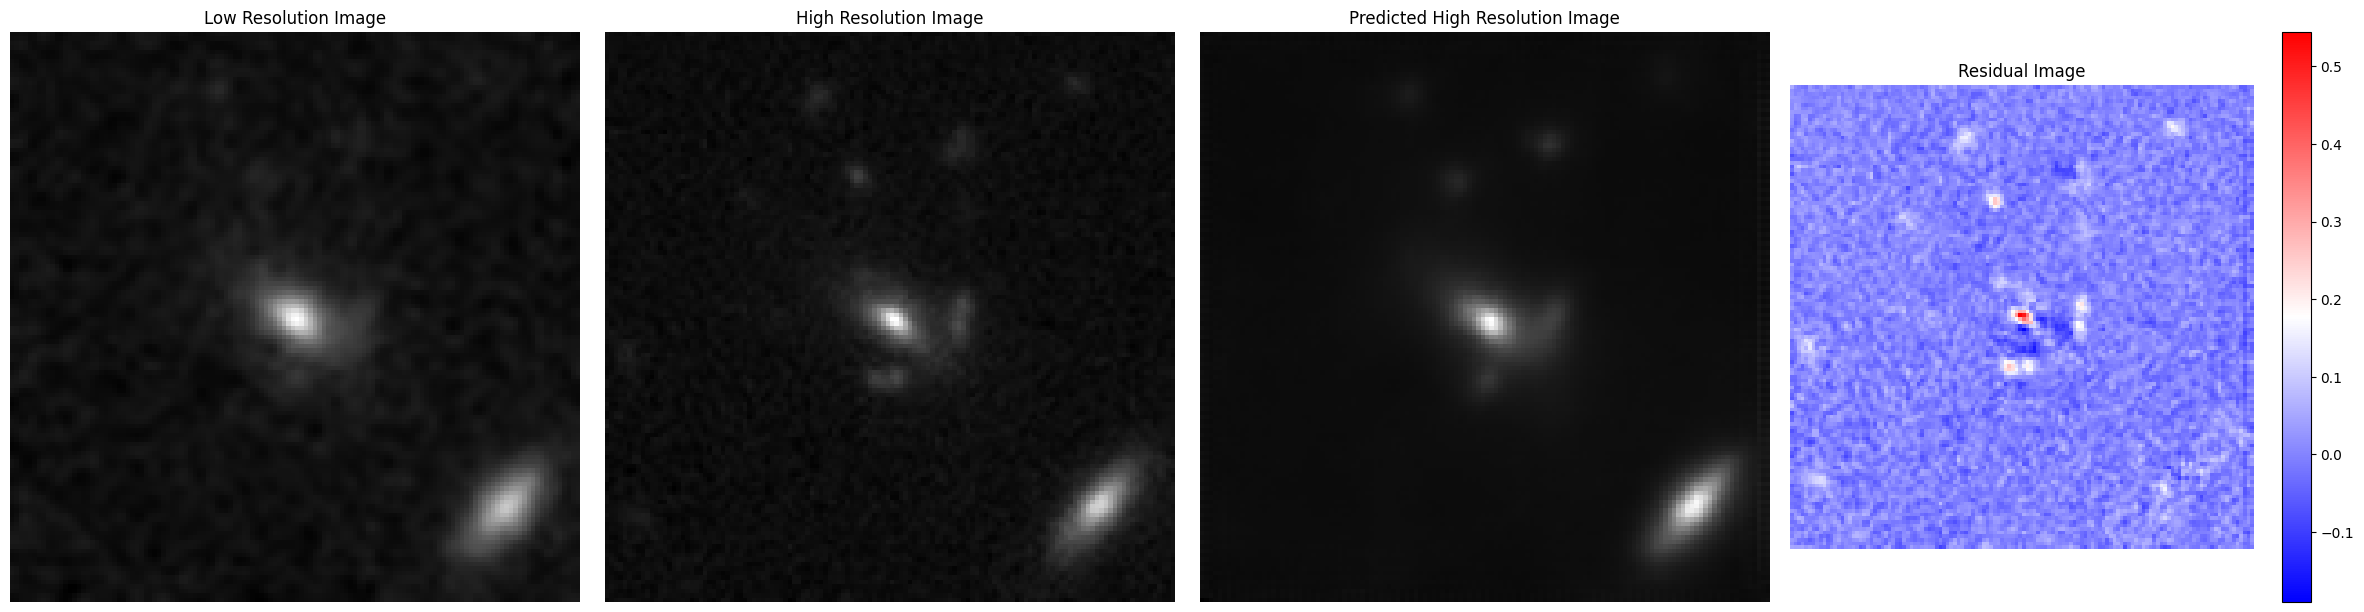

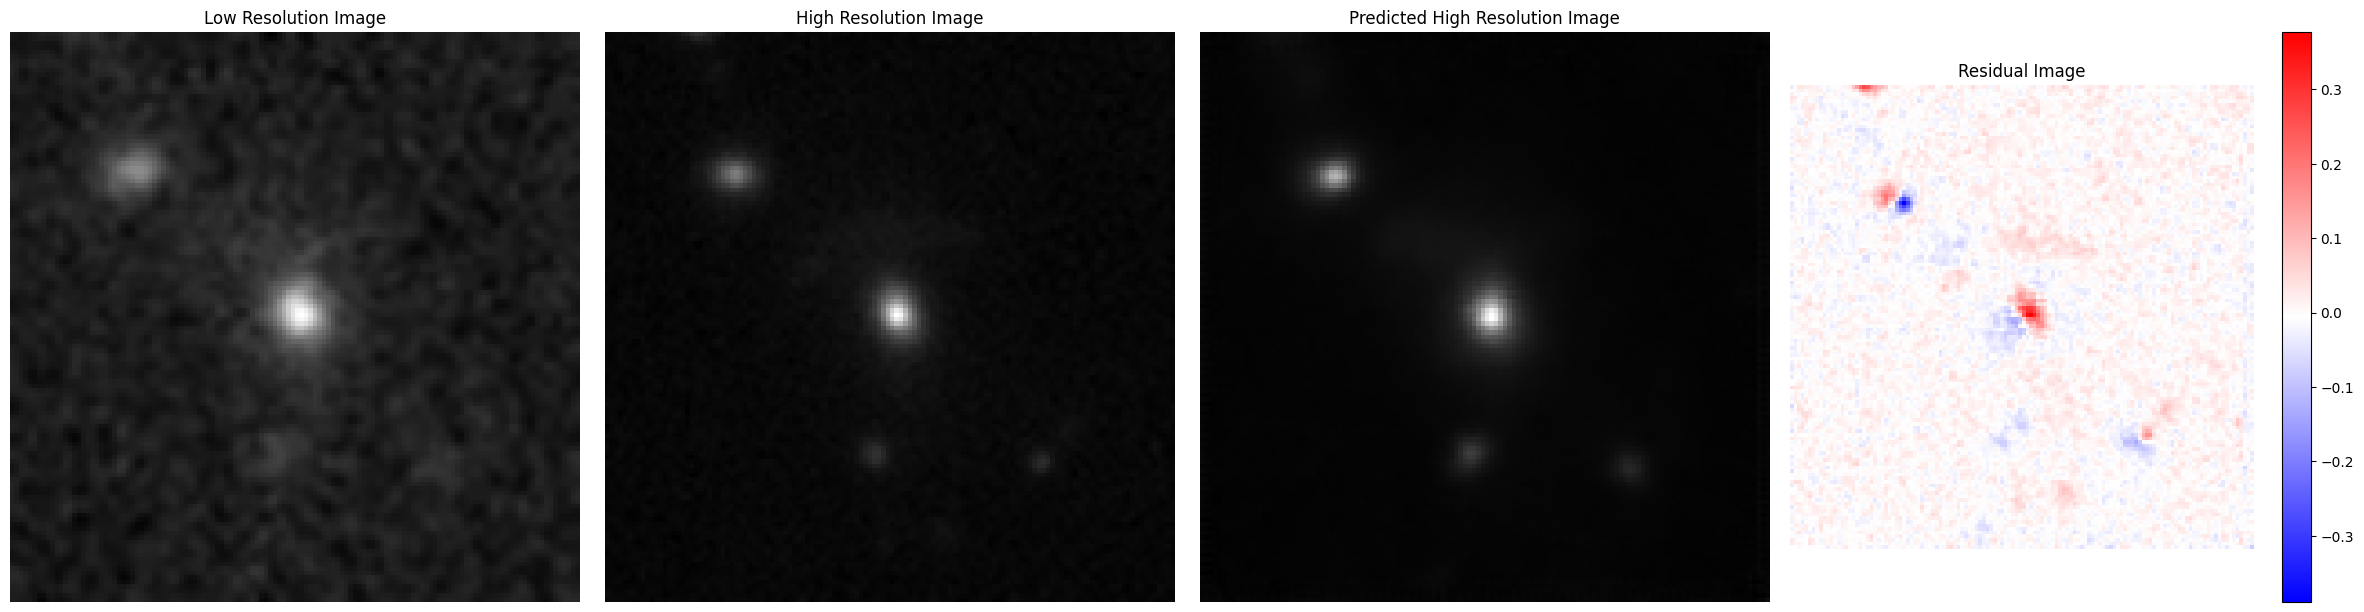

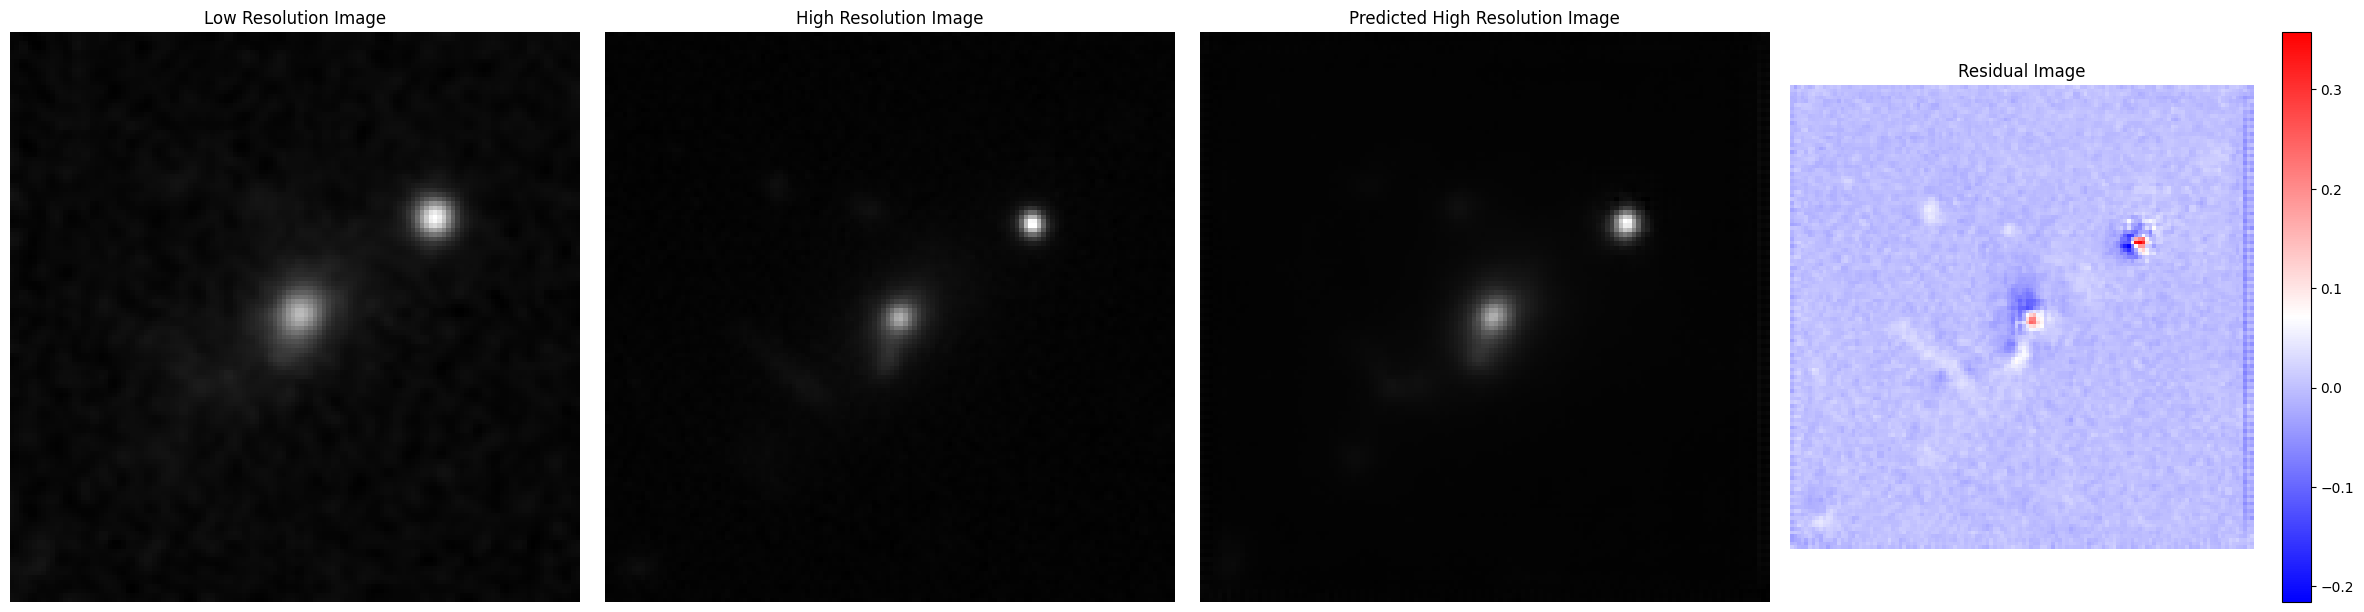

Evaluating:   6%|▌         | 2/36 [00:10<03:05,  5.44s/it]

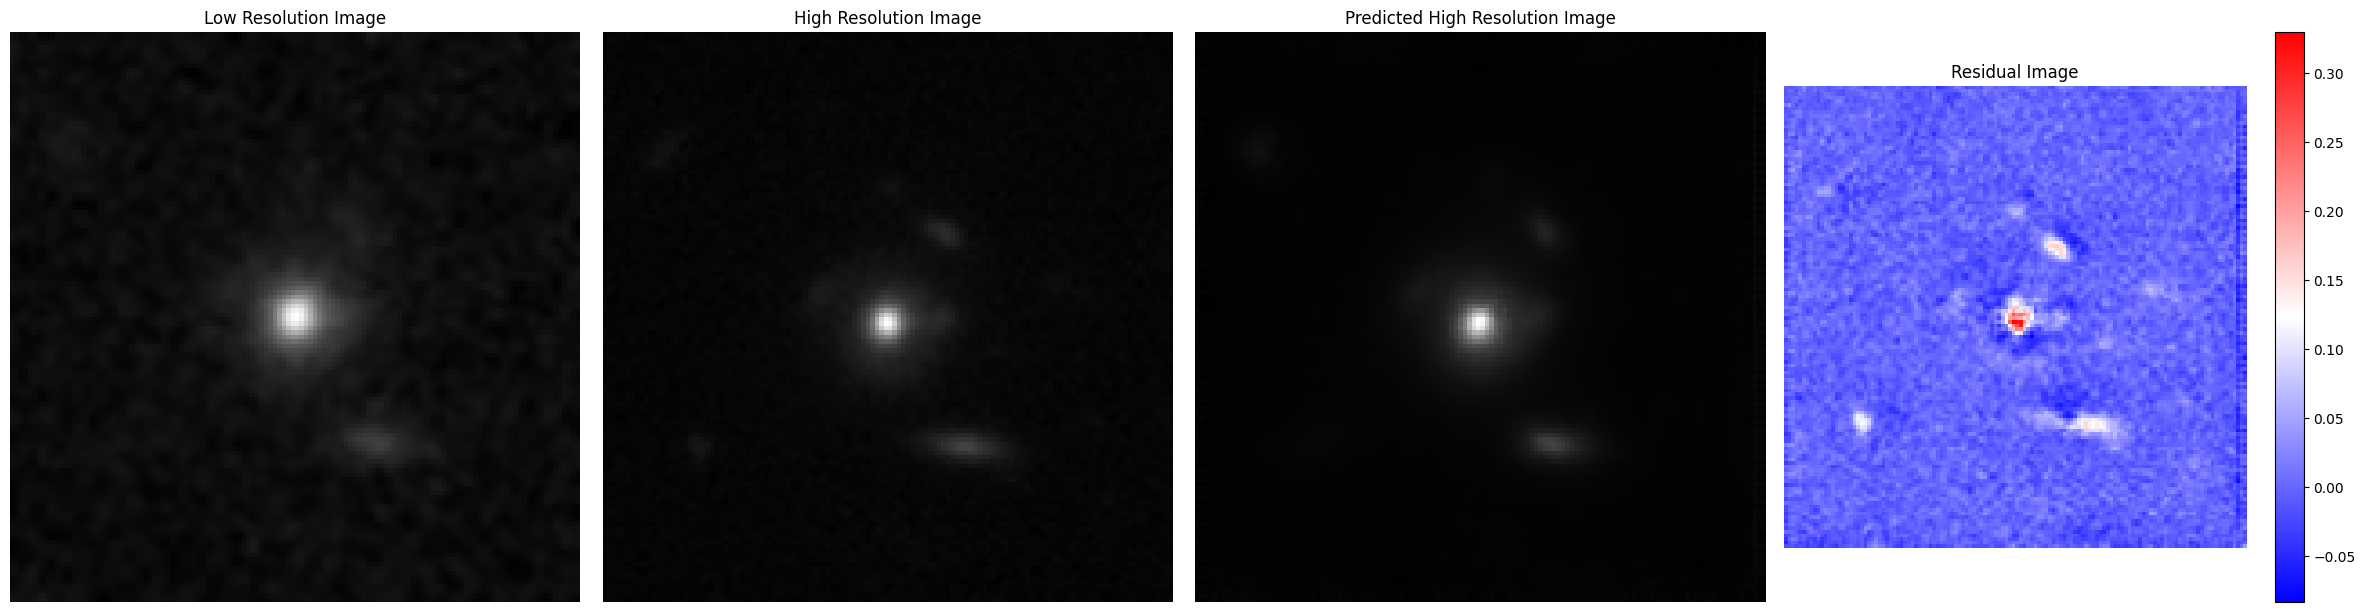

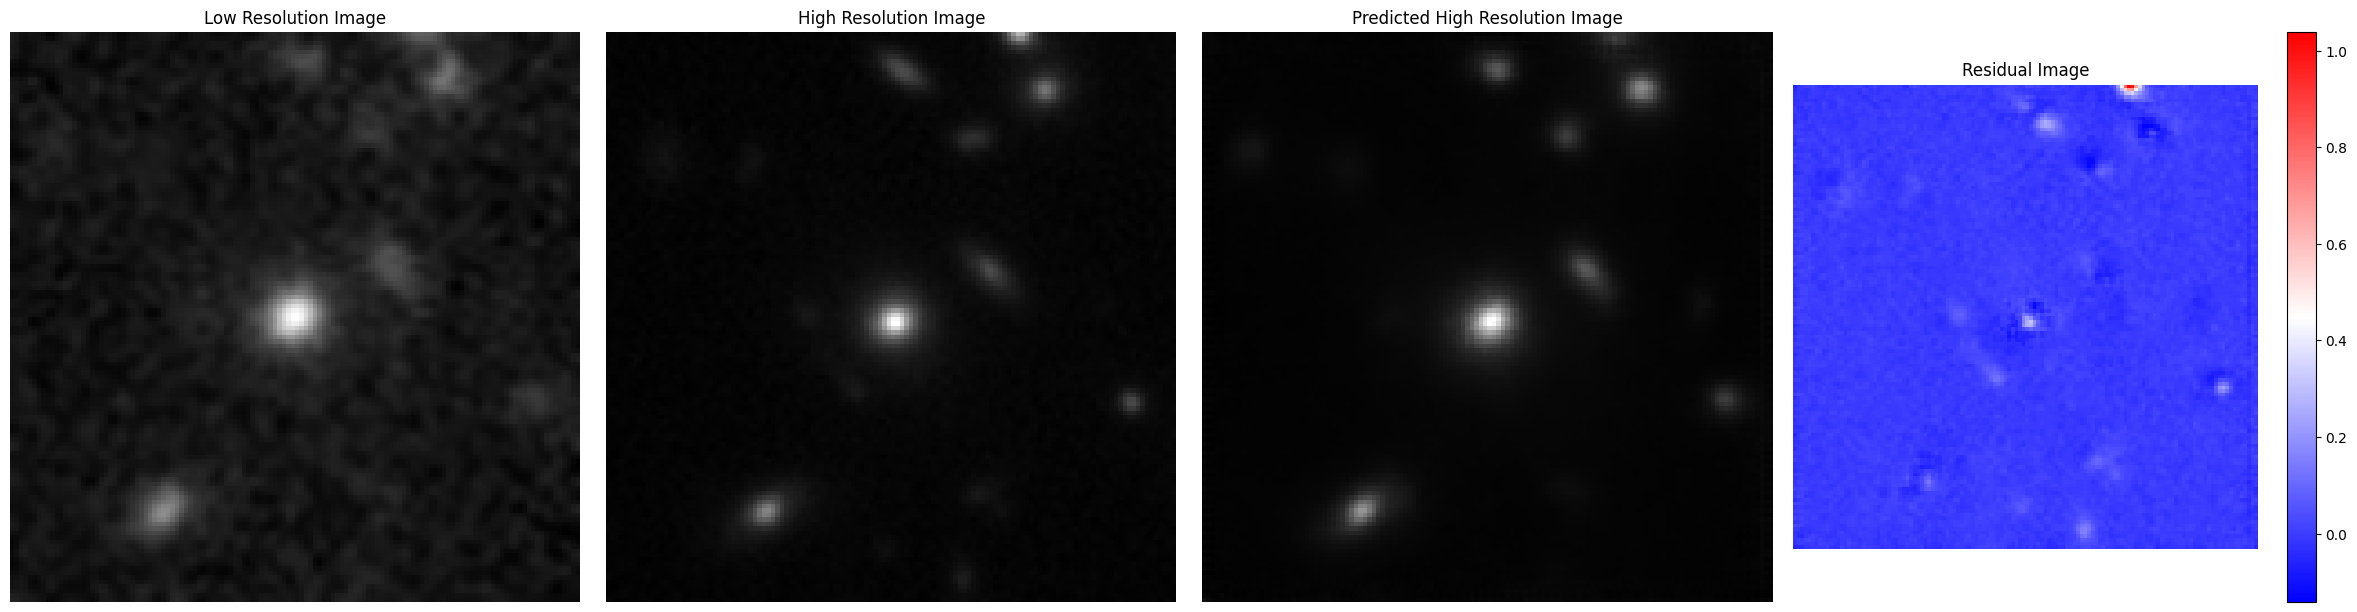

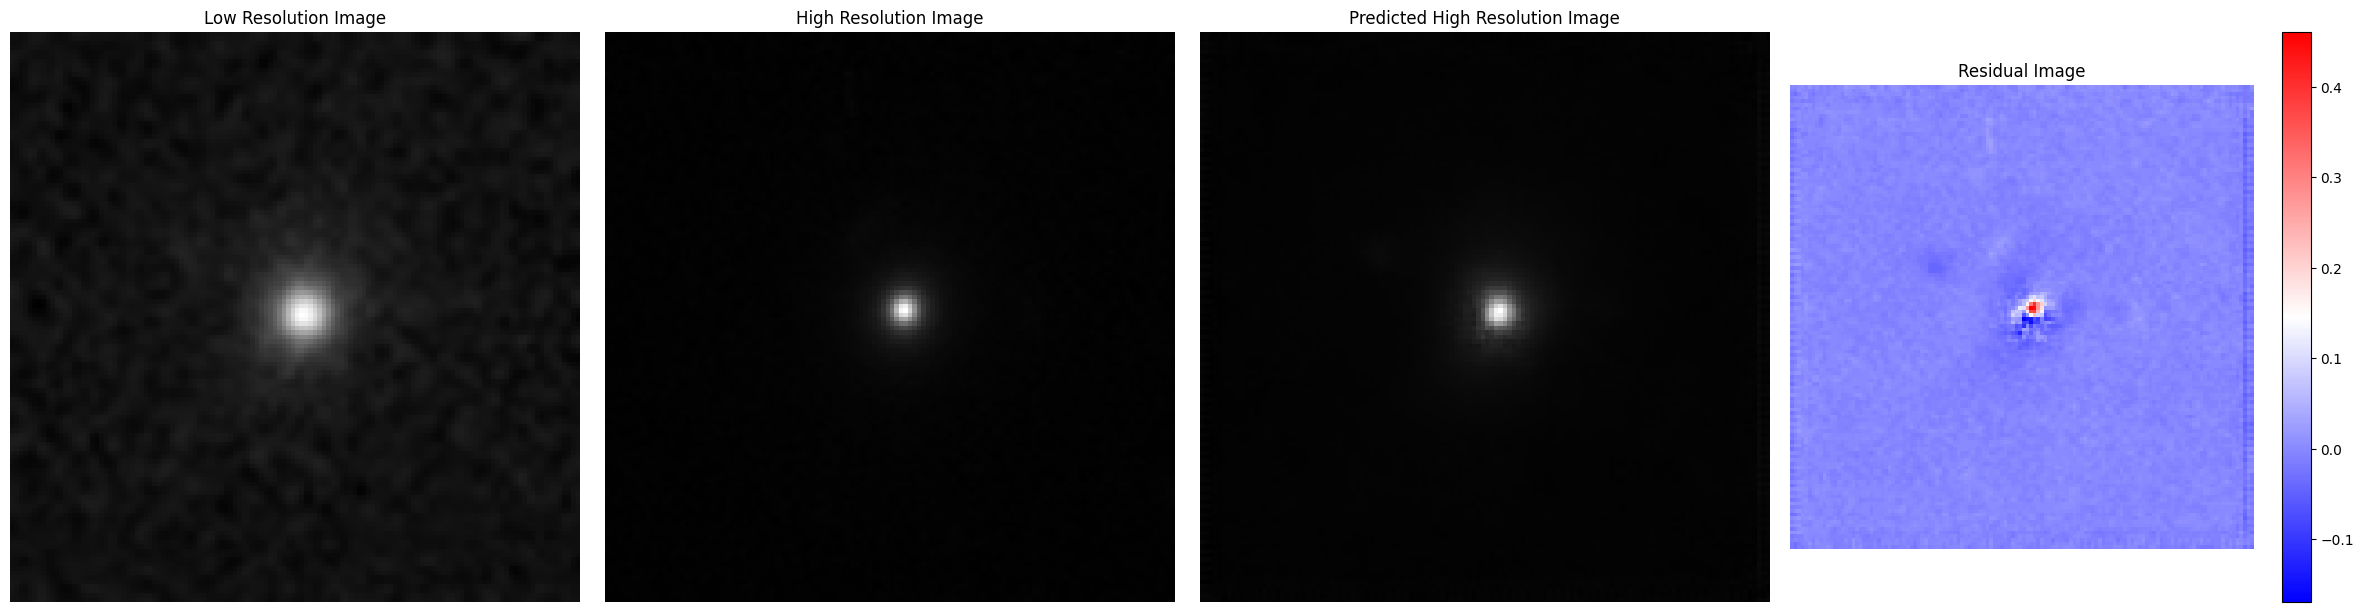

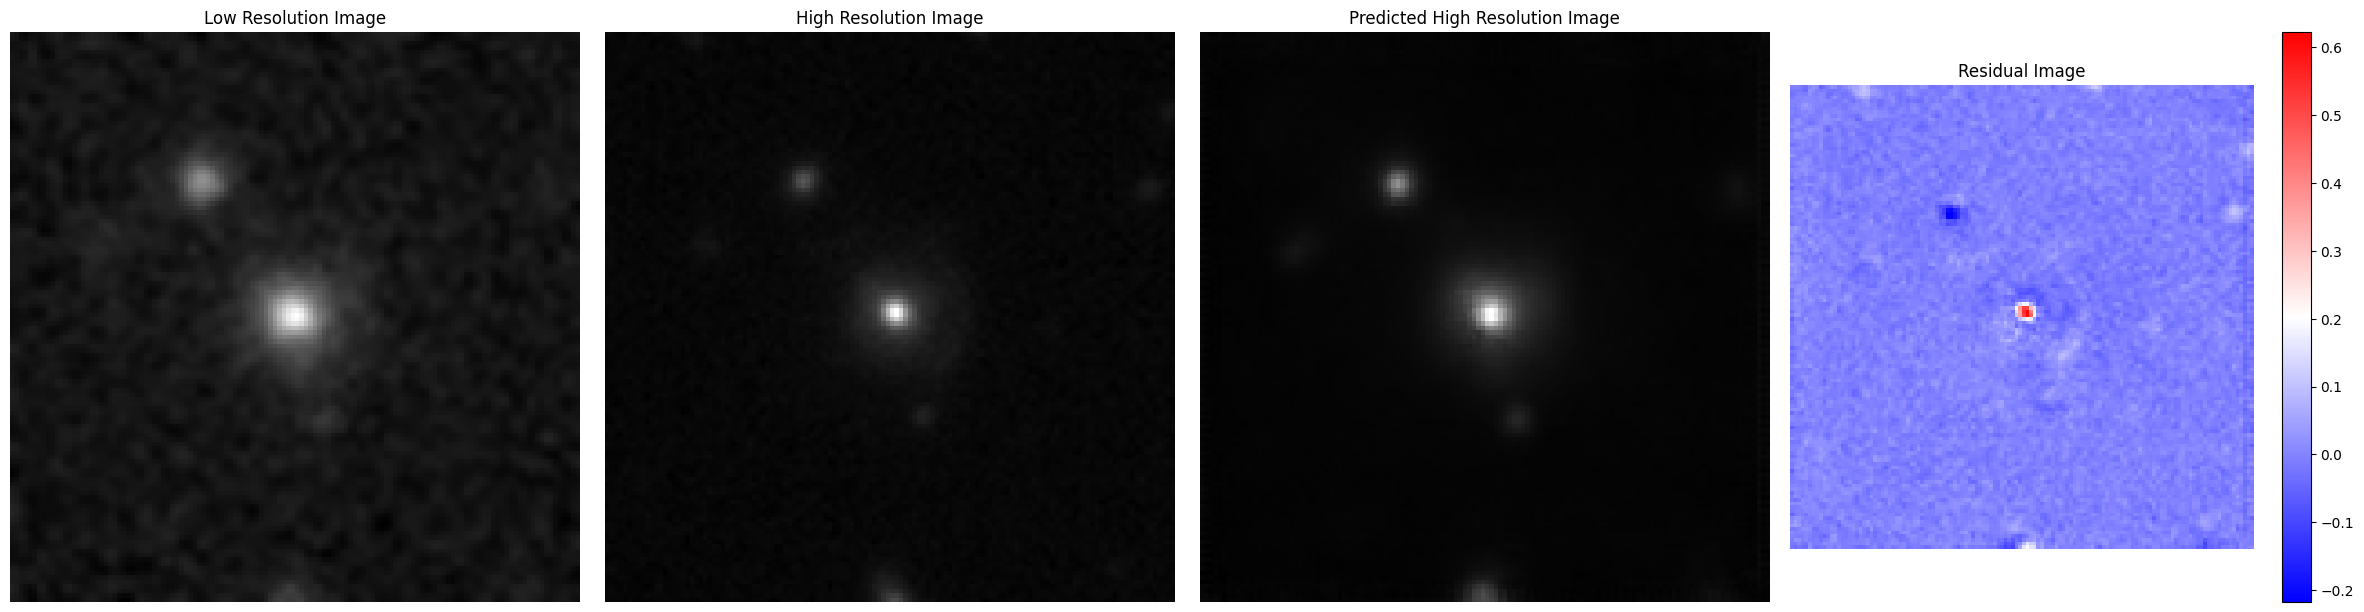

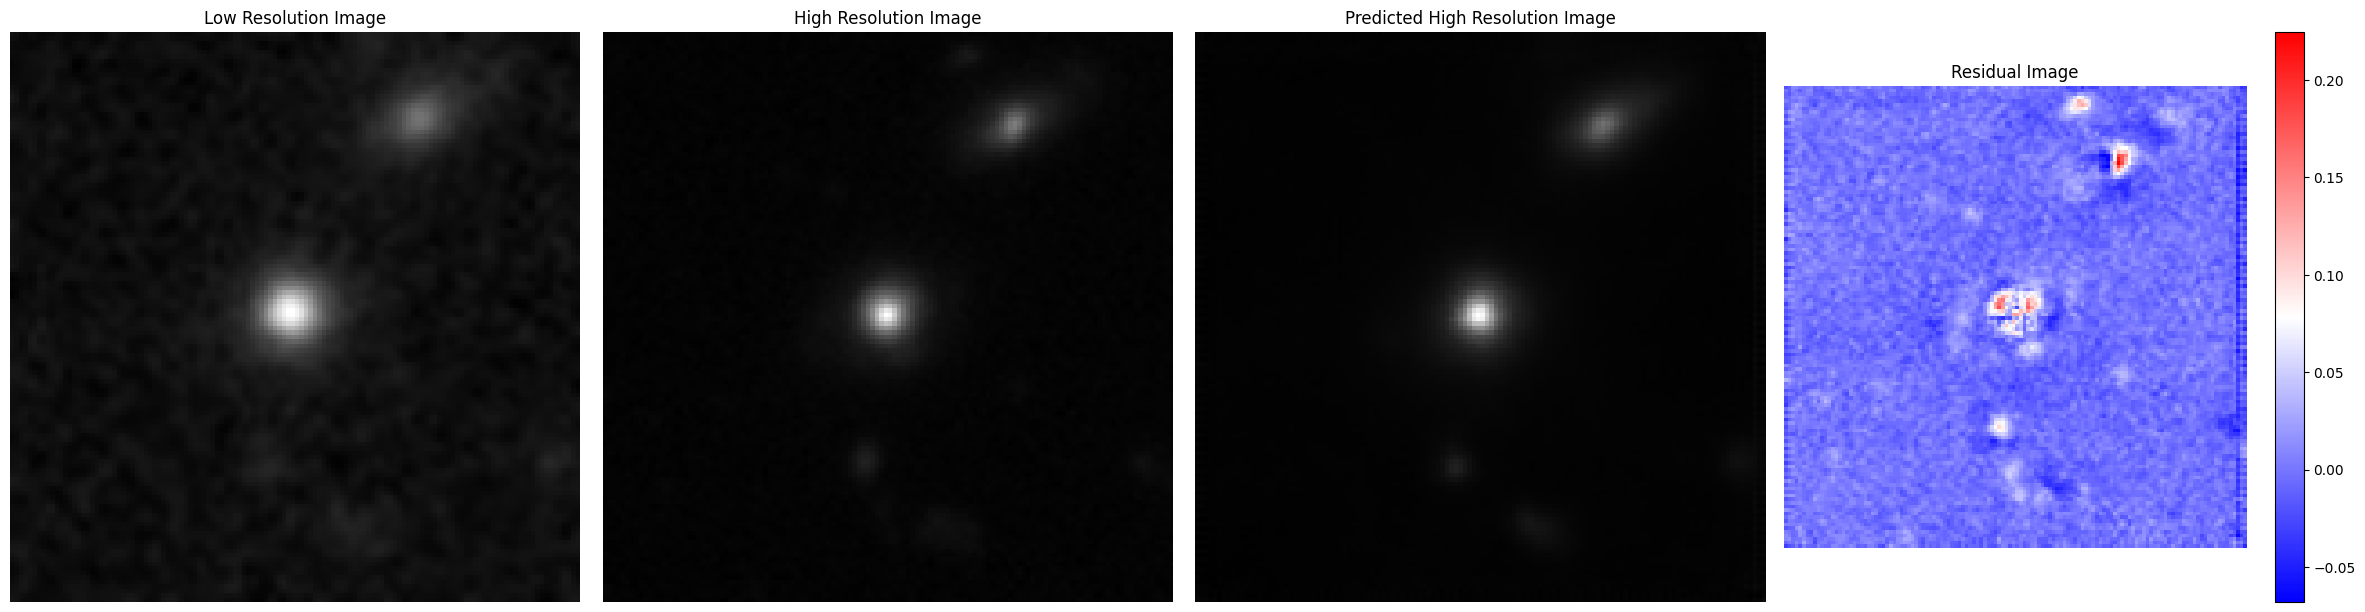

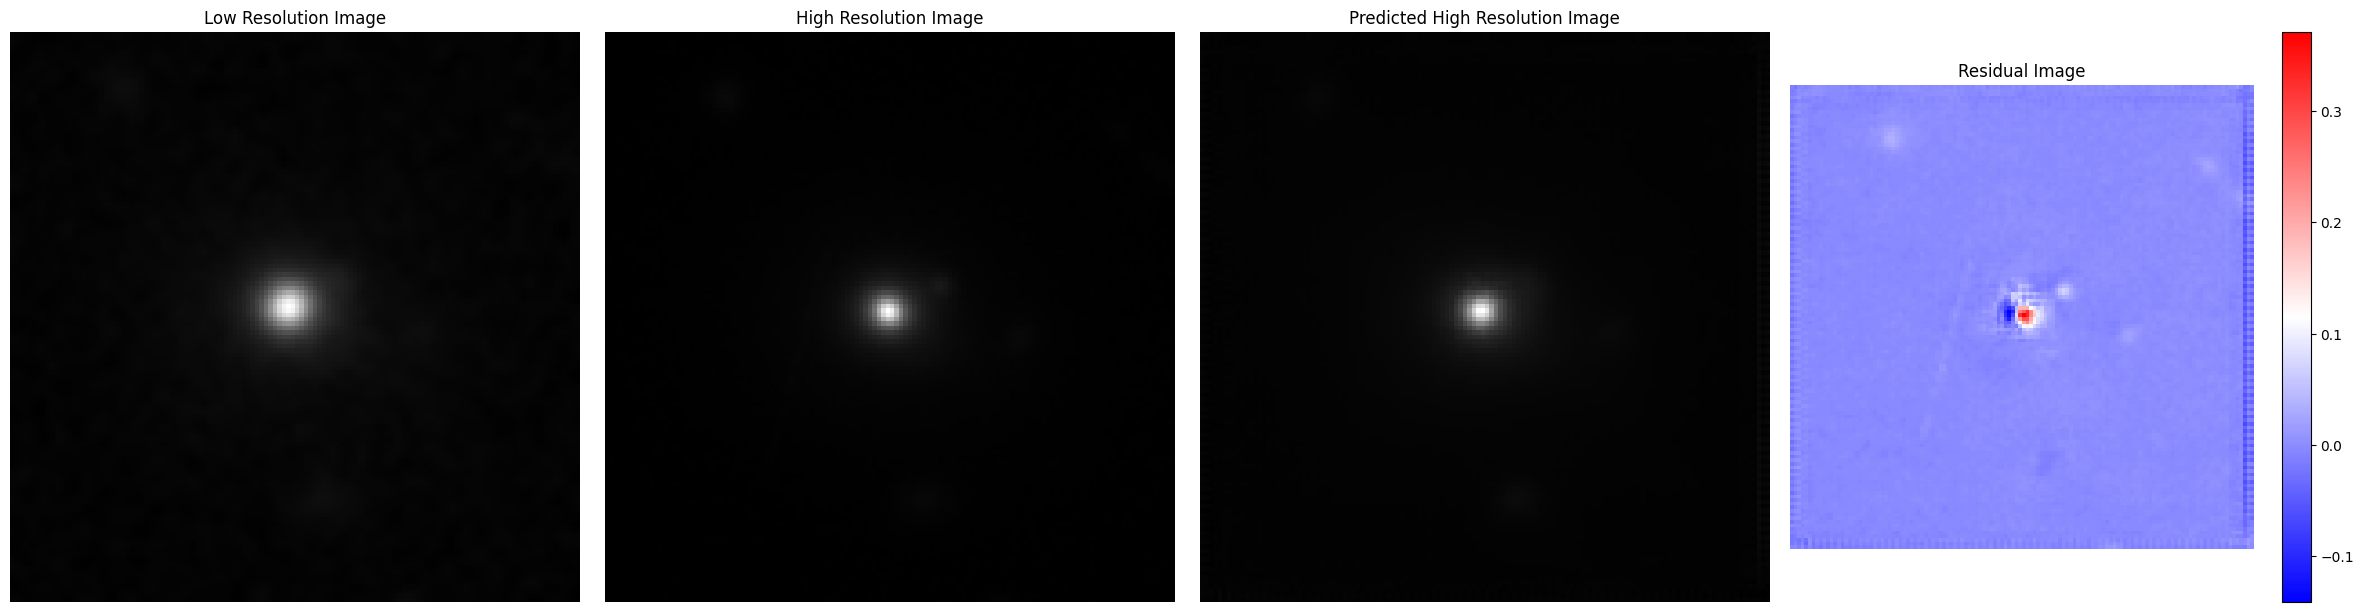

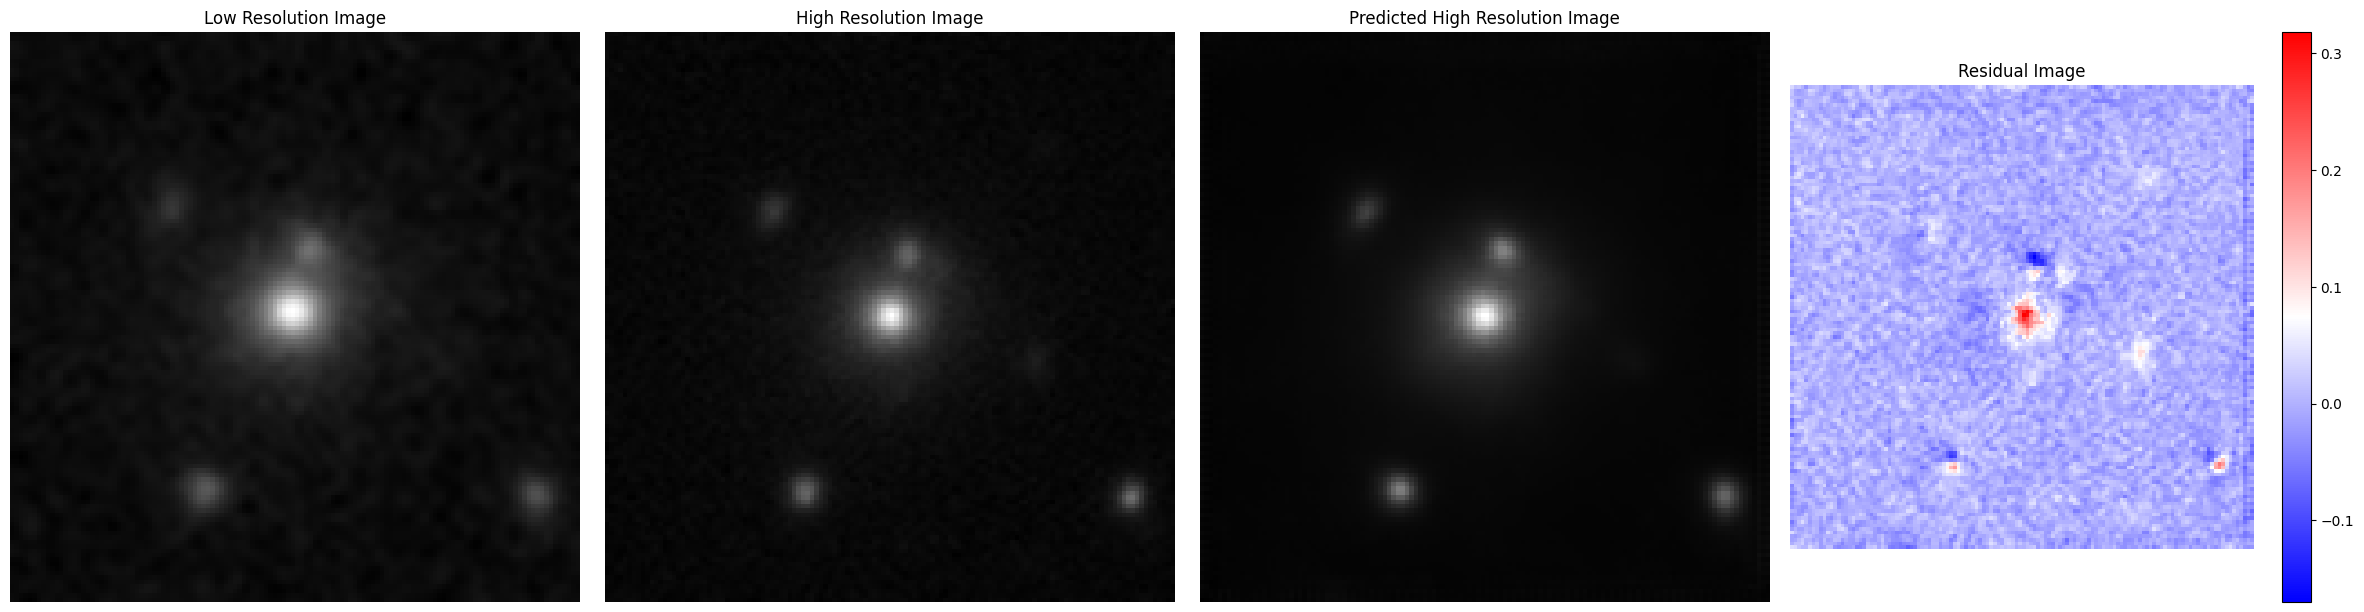

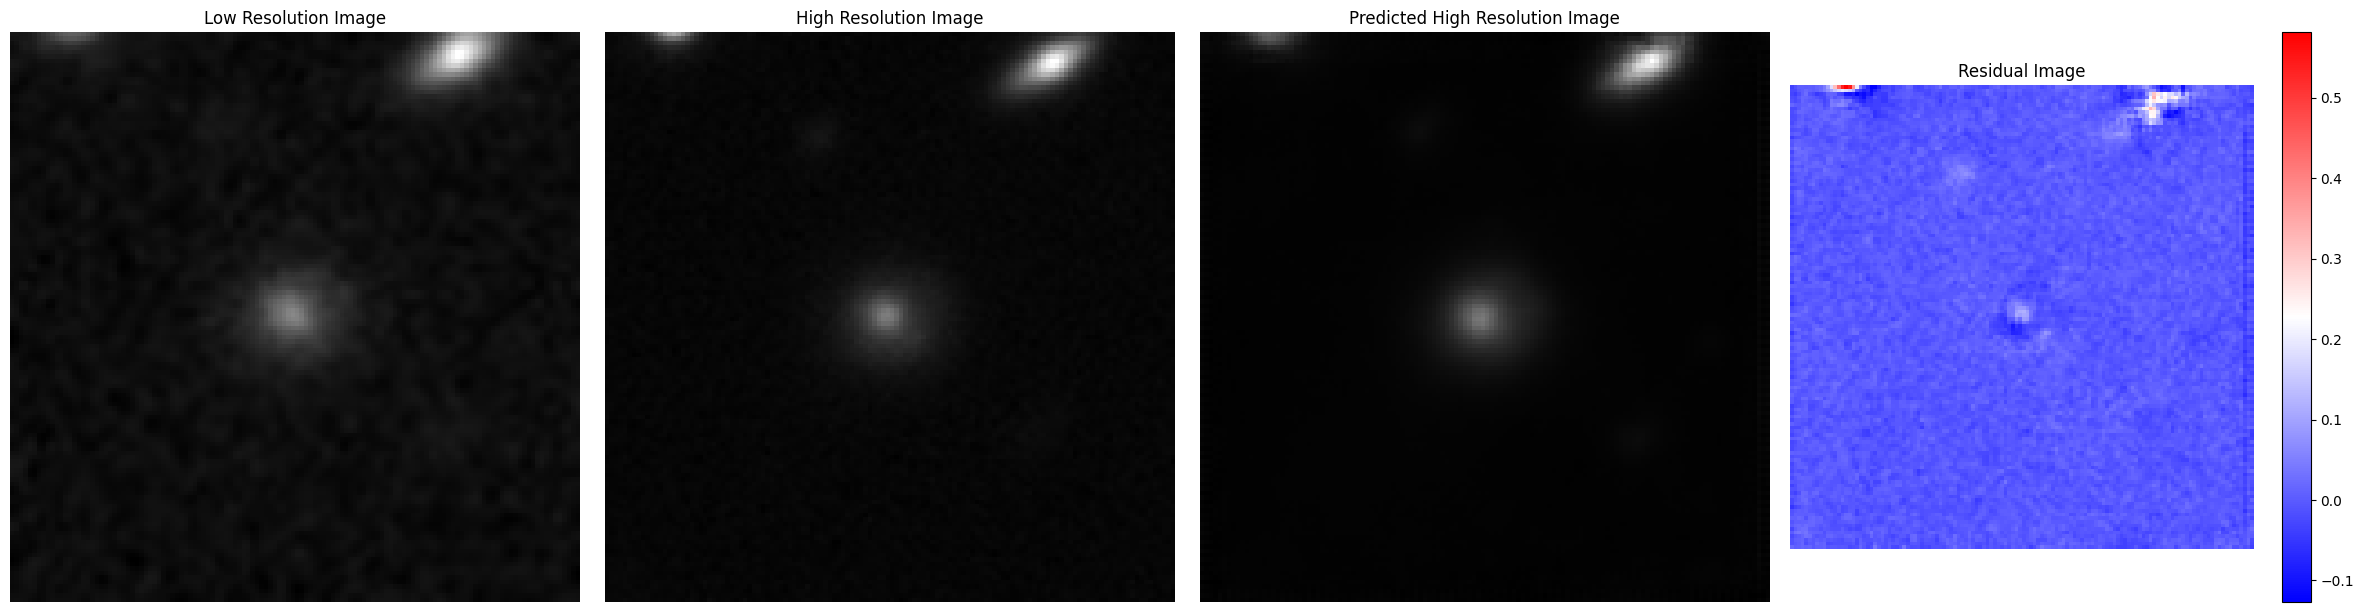

Evaluating:   8%|▊         | 3/36 [00:16<02:59,  5.43s/it]

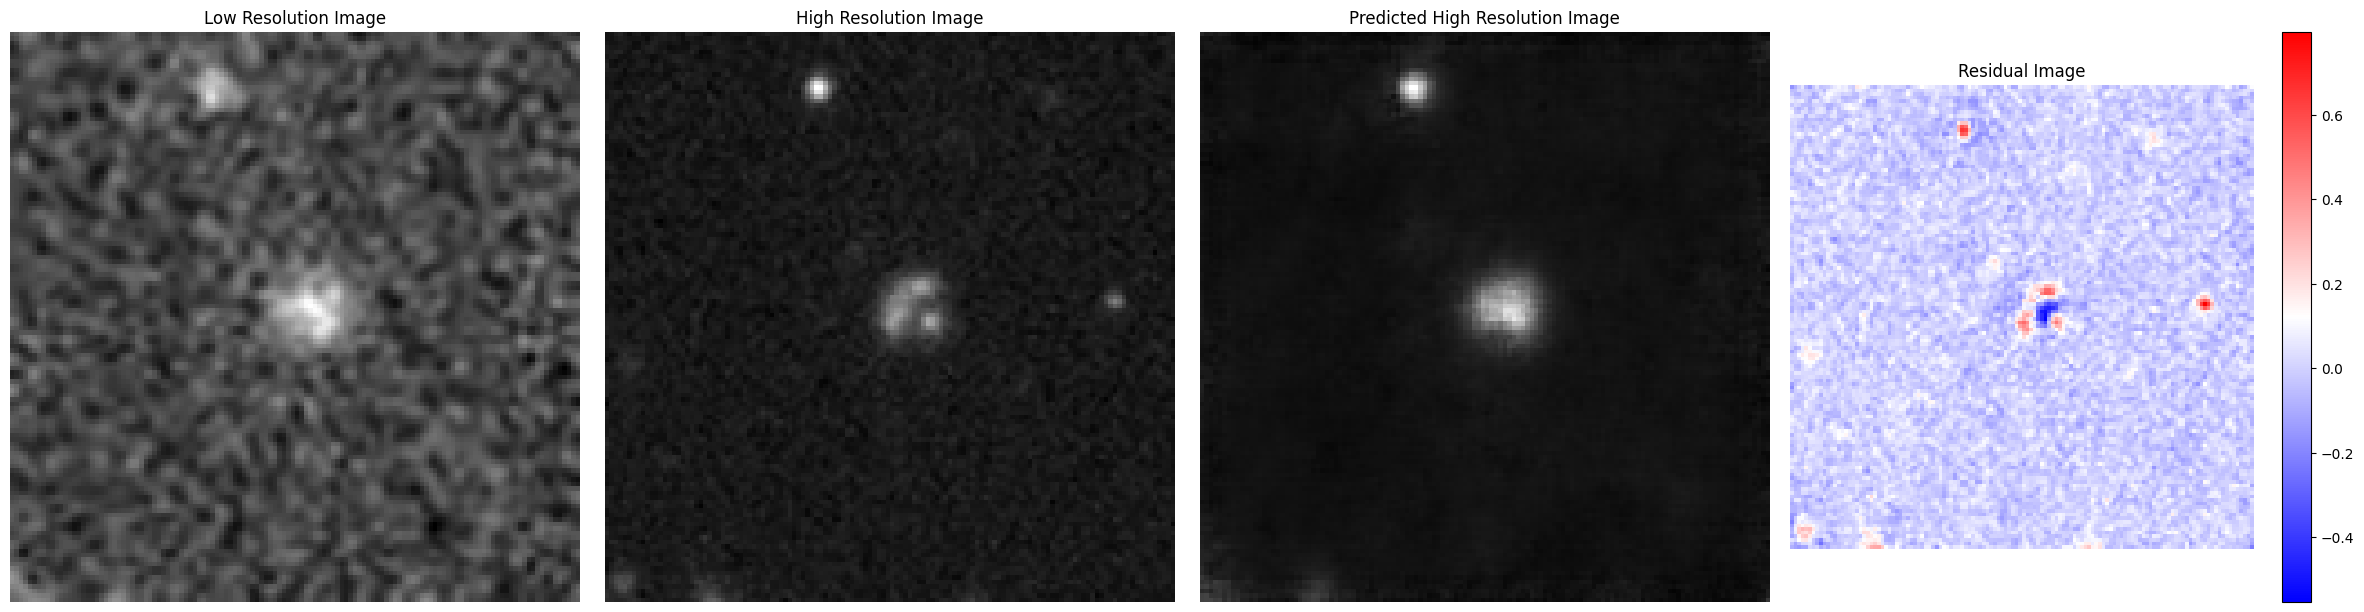

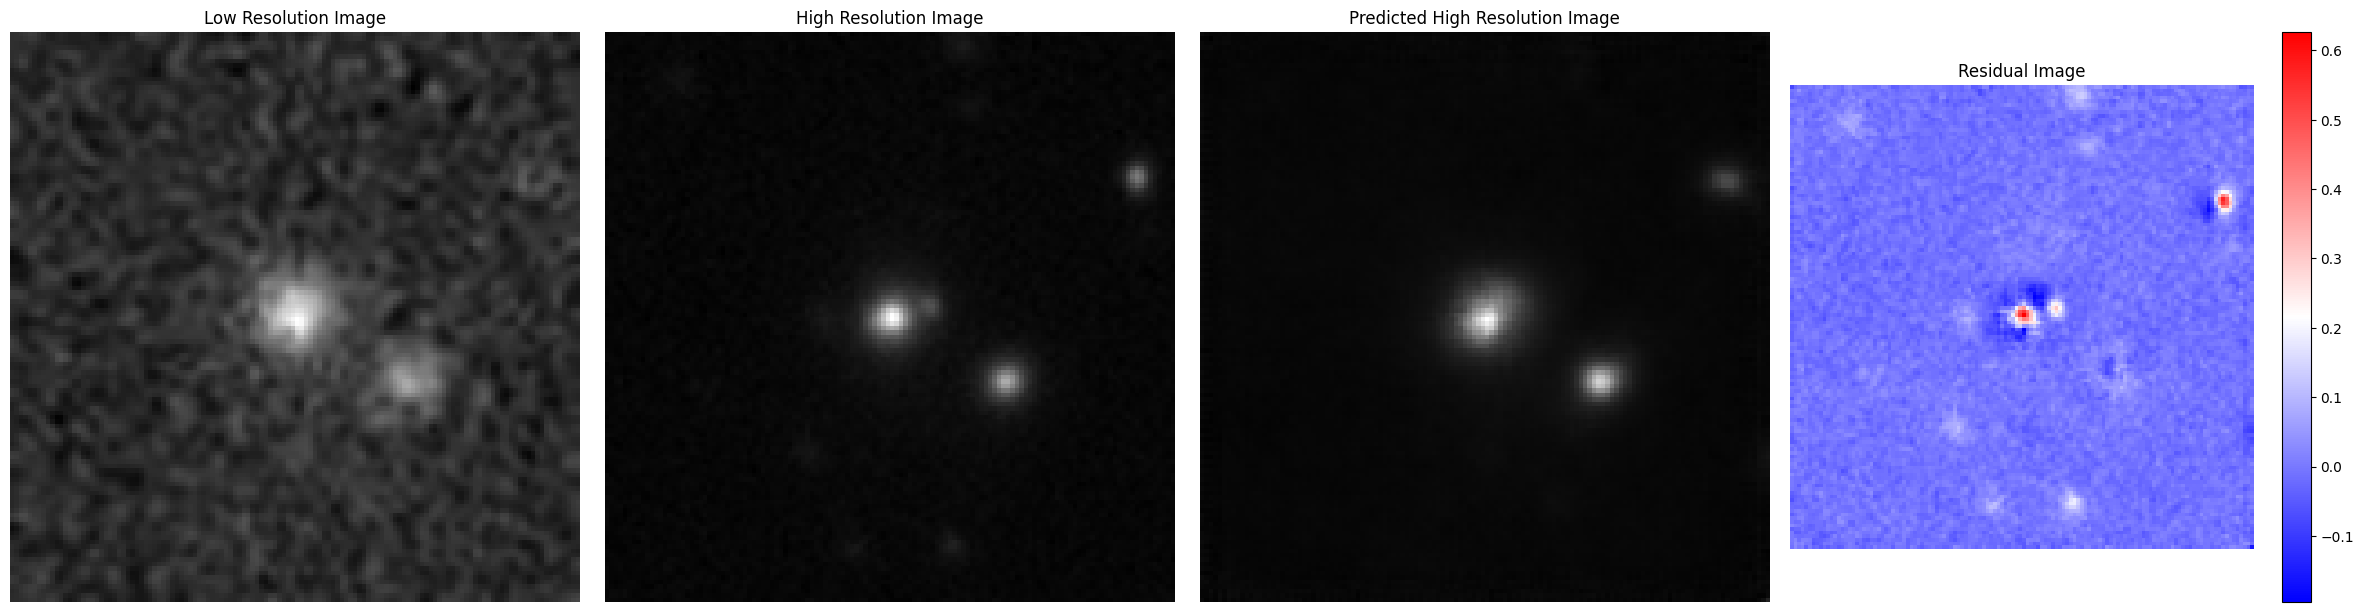

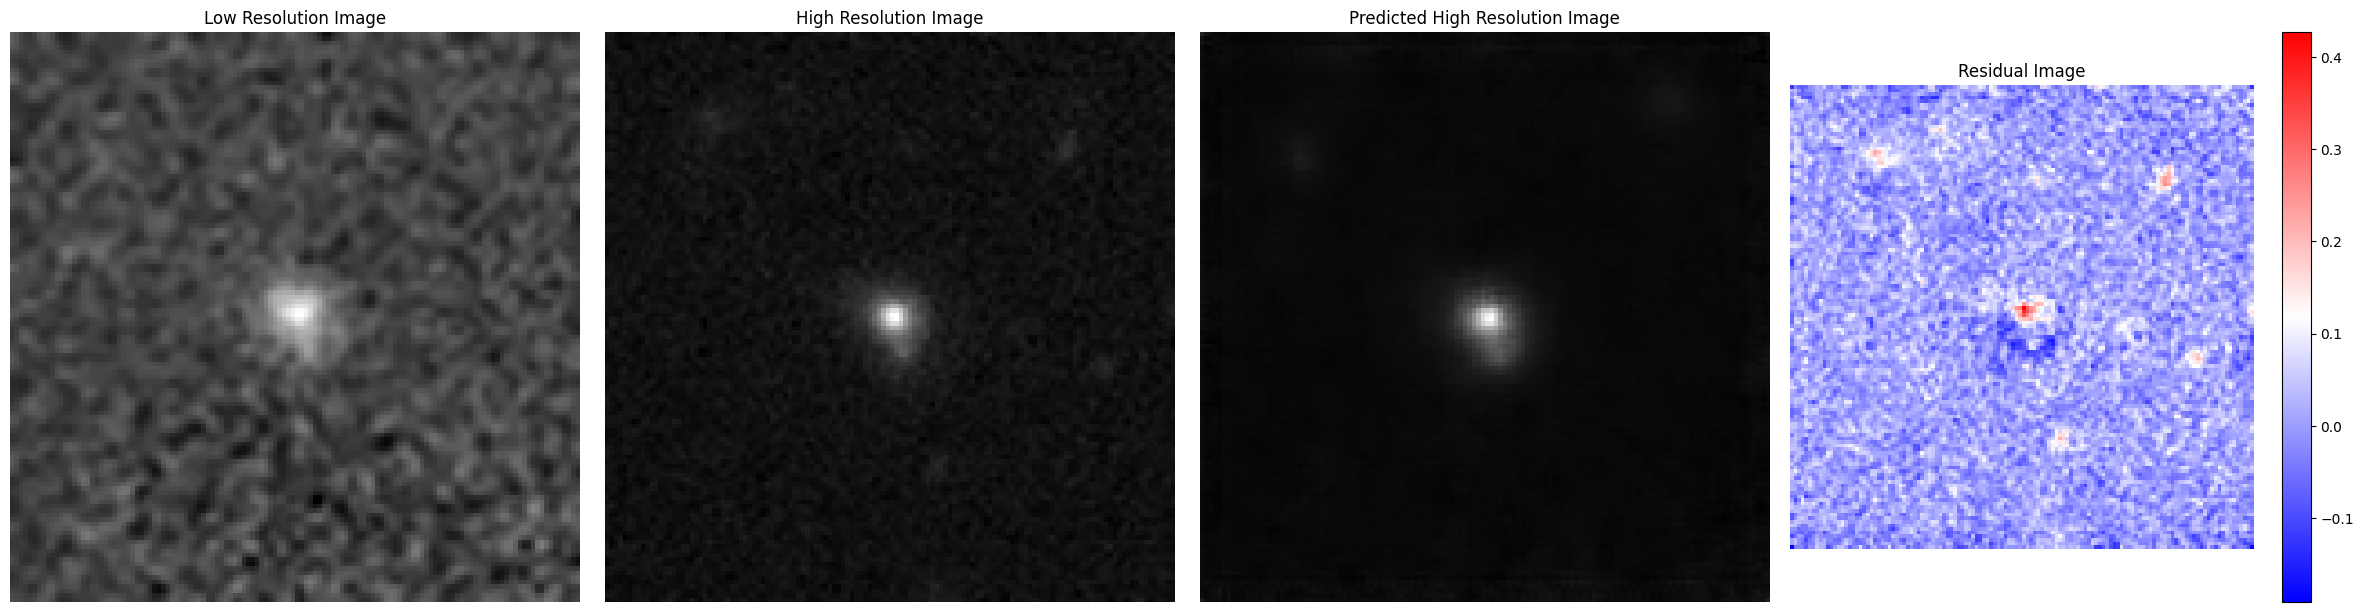

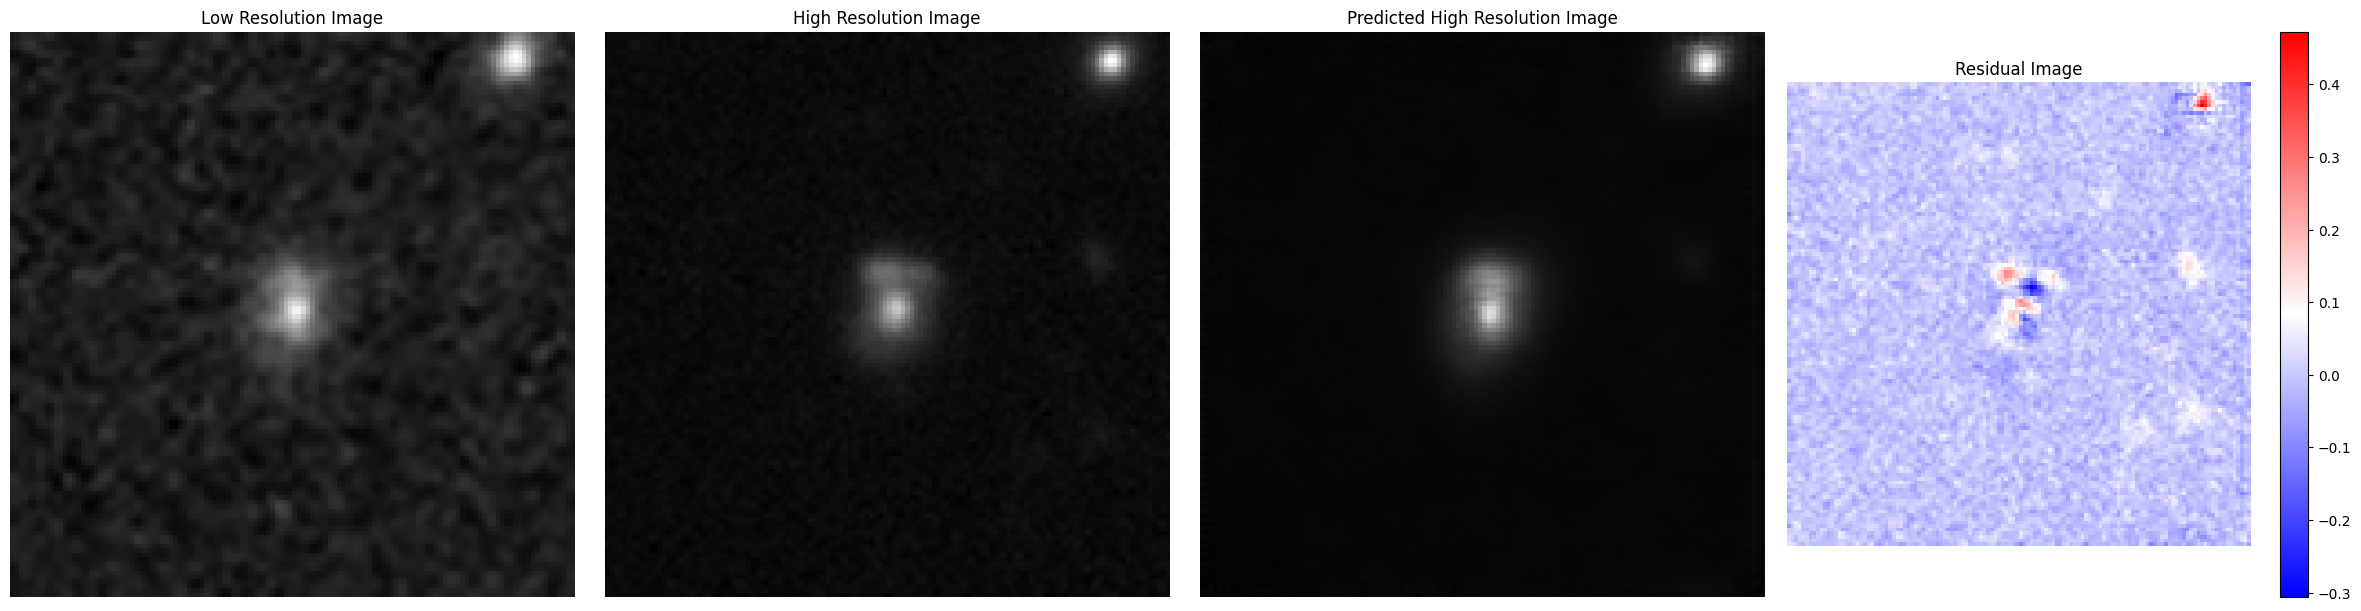

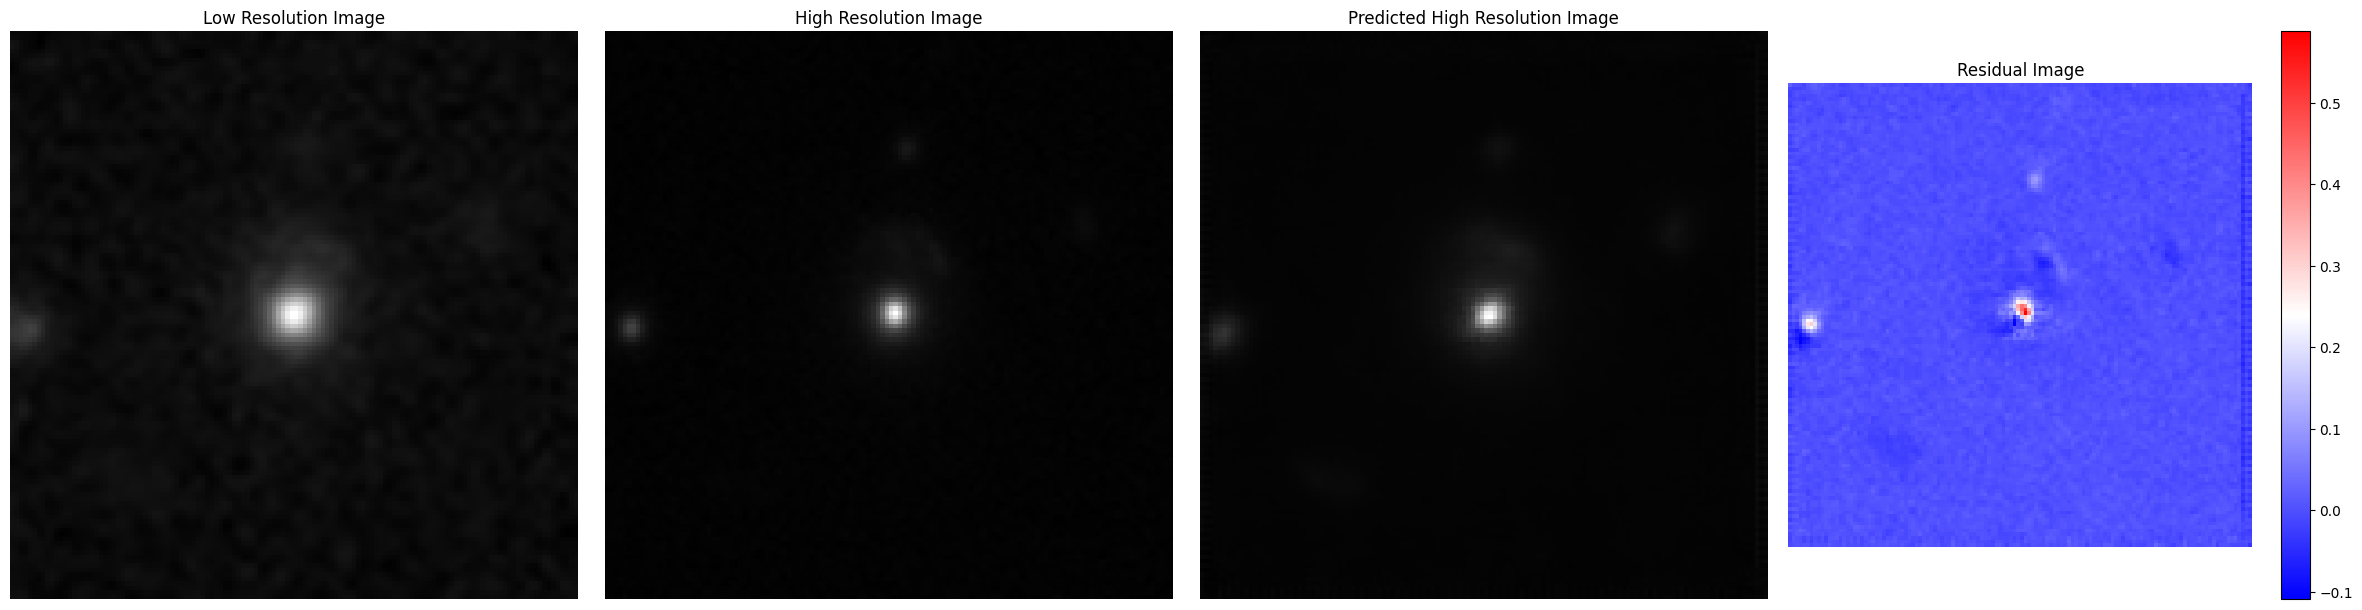

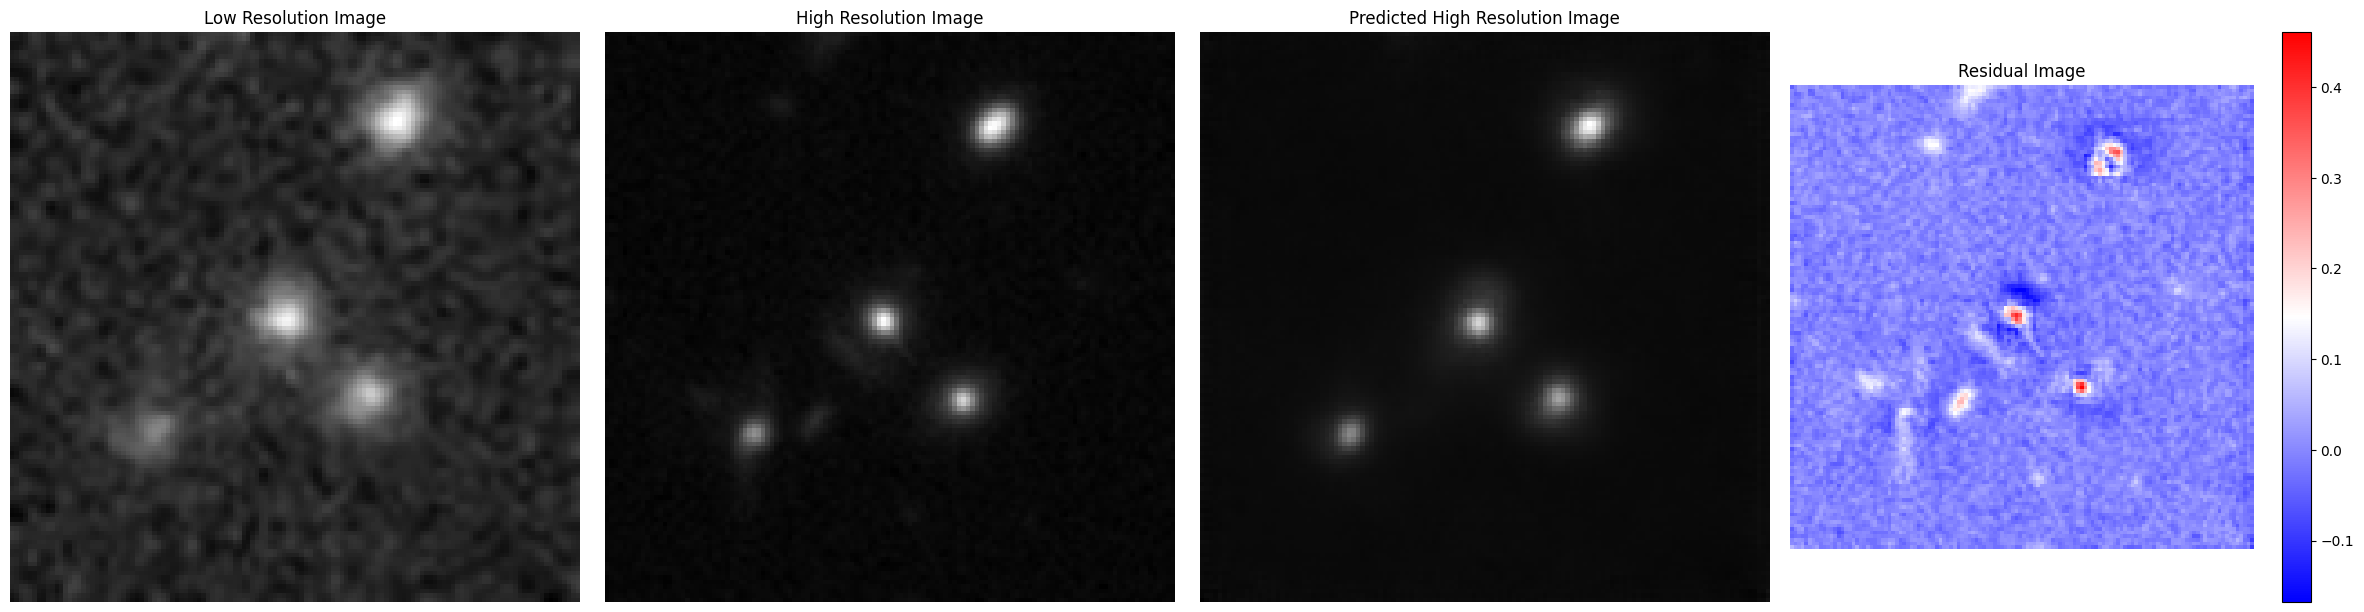

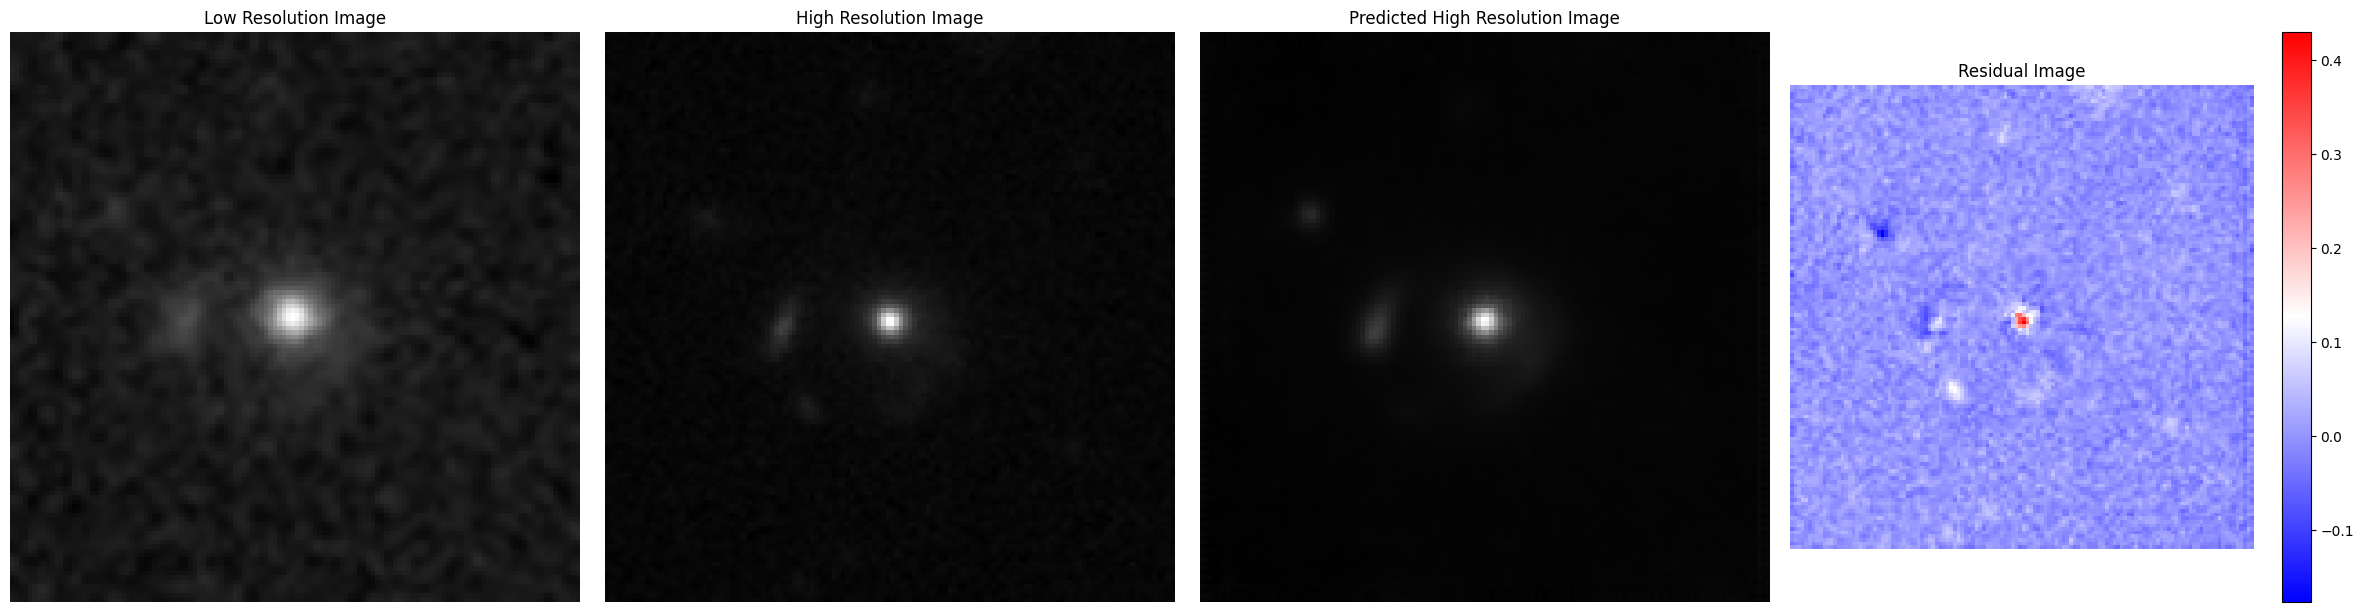

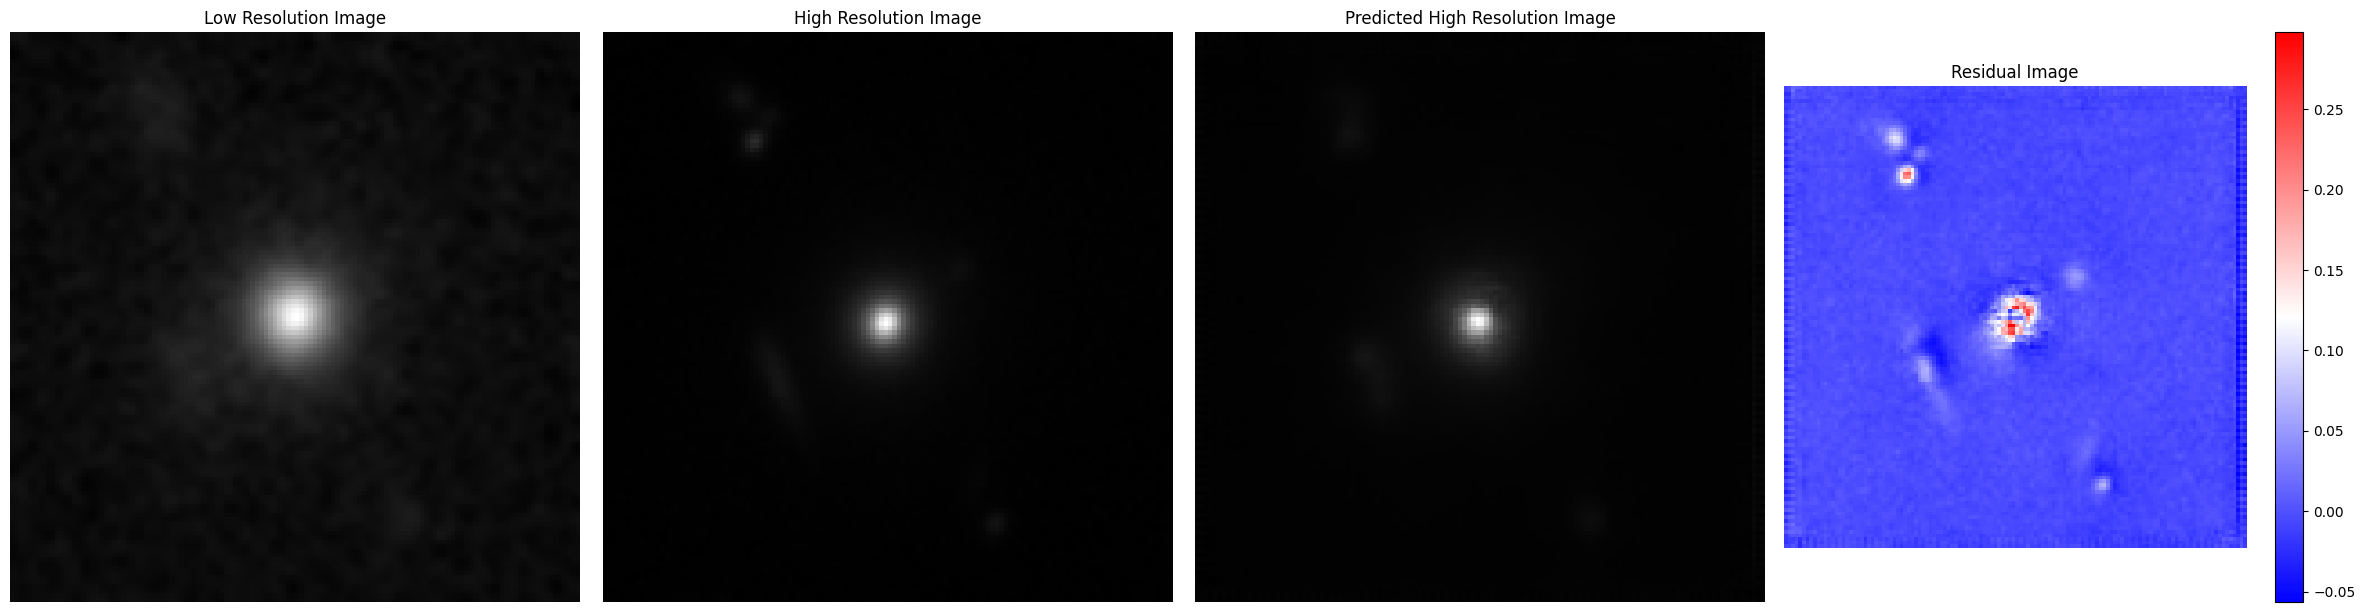

Evaluating:  11%|█         | 4/36 [00:21<02:55,  5.47s/it]

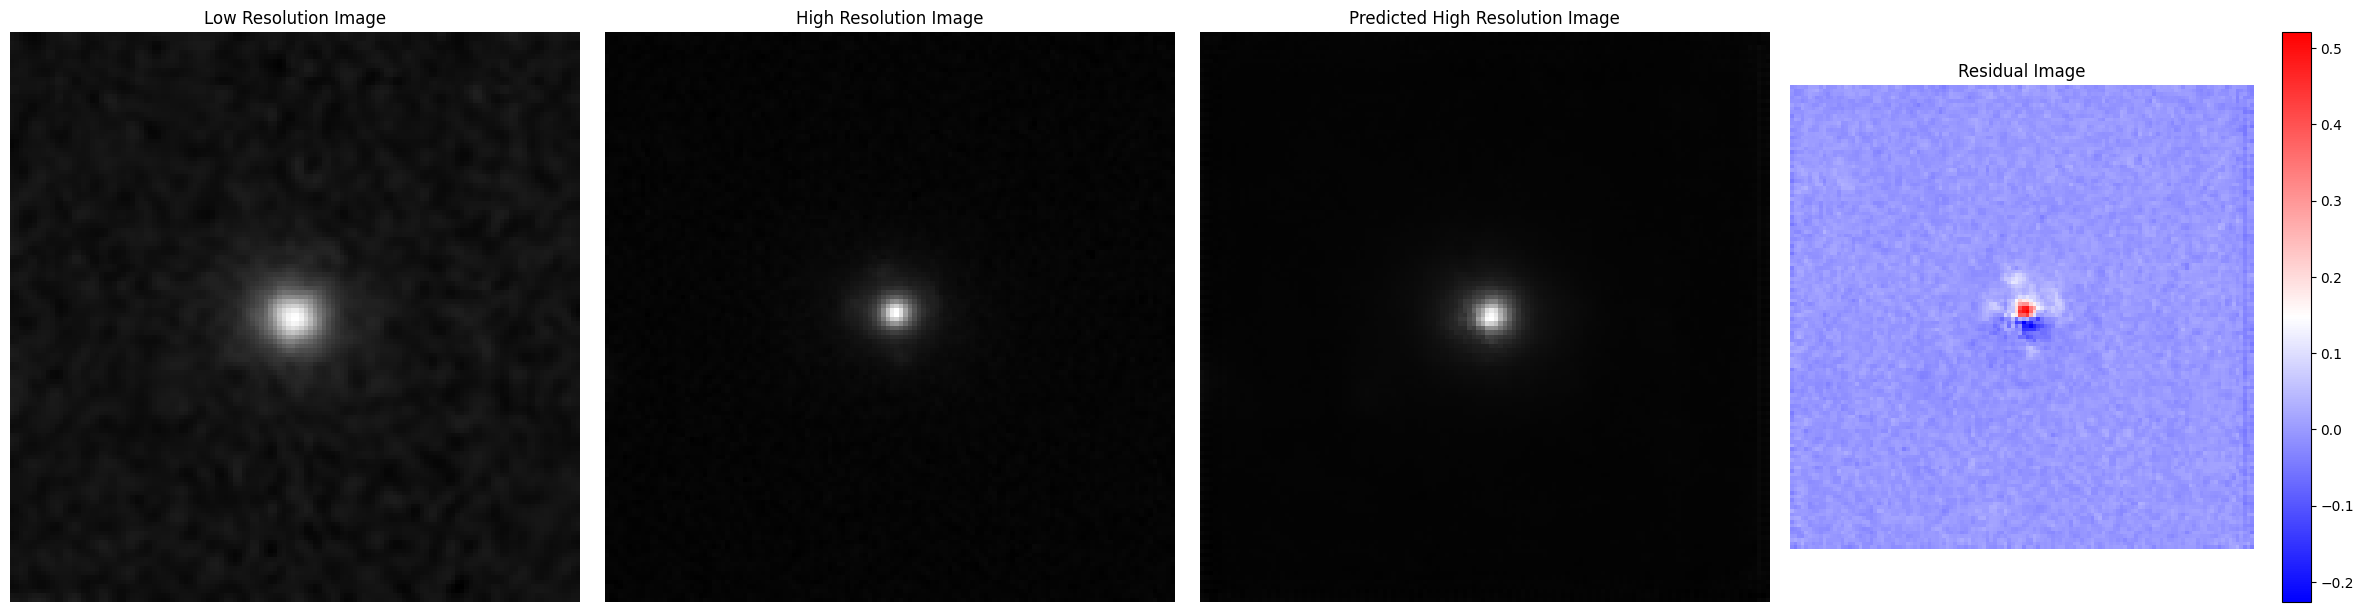

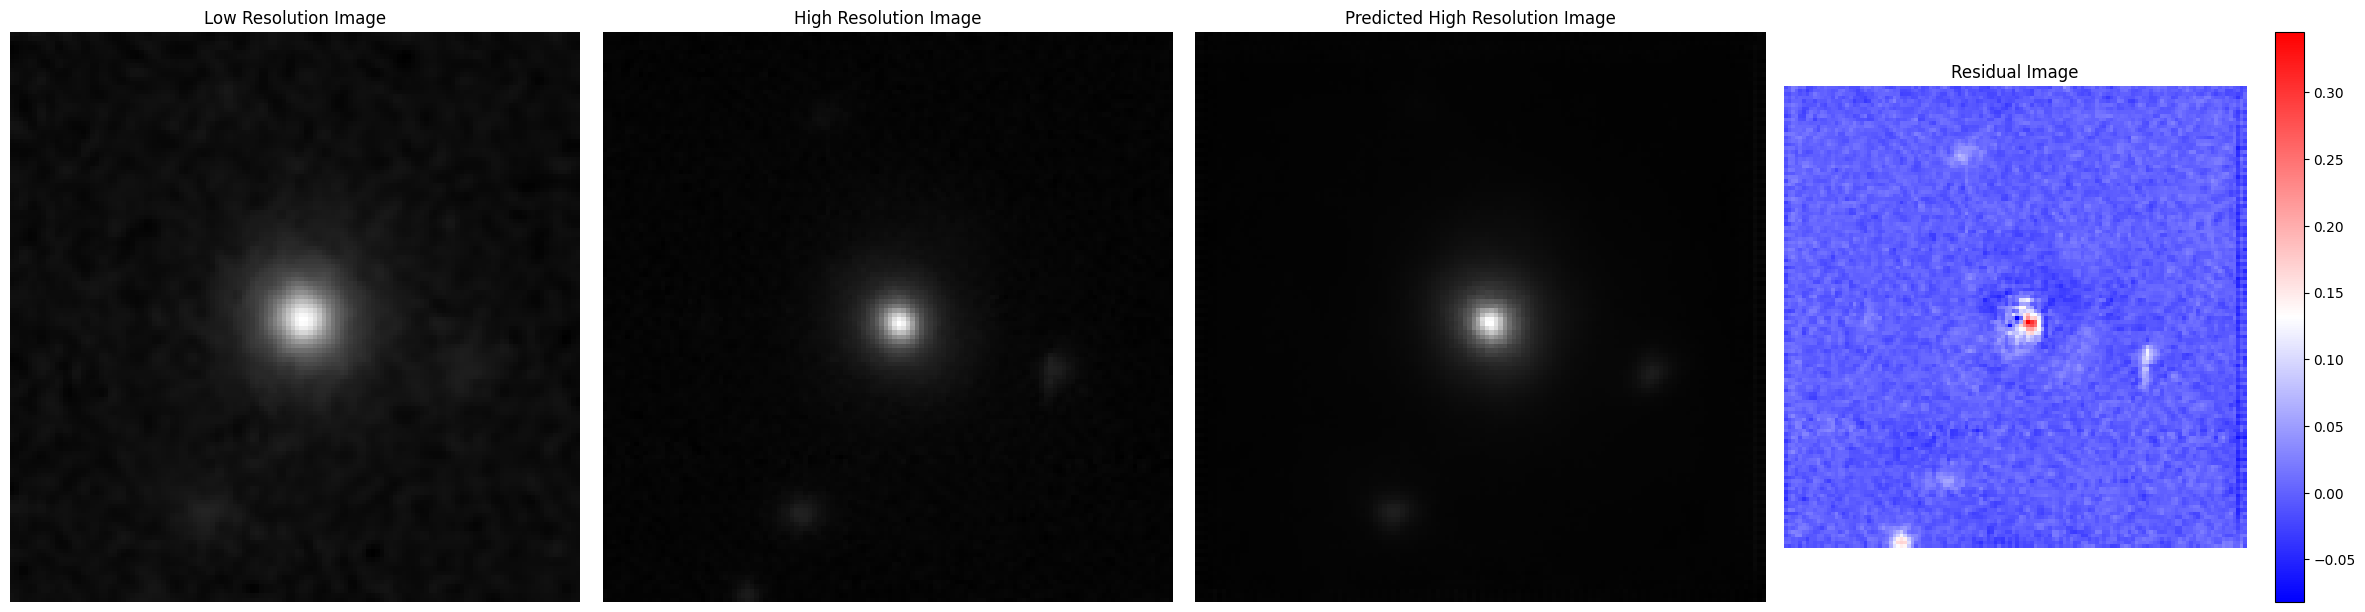

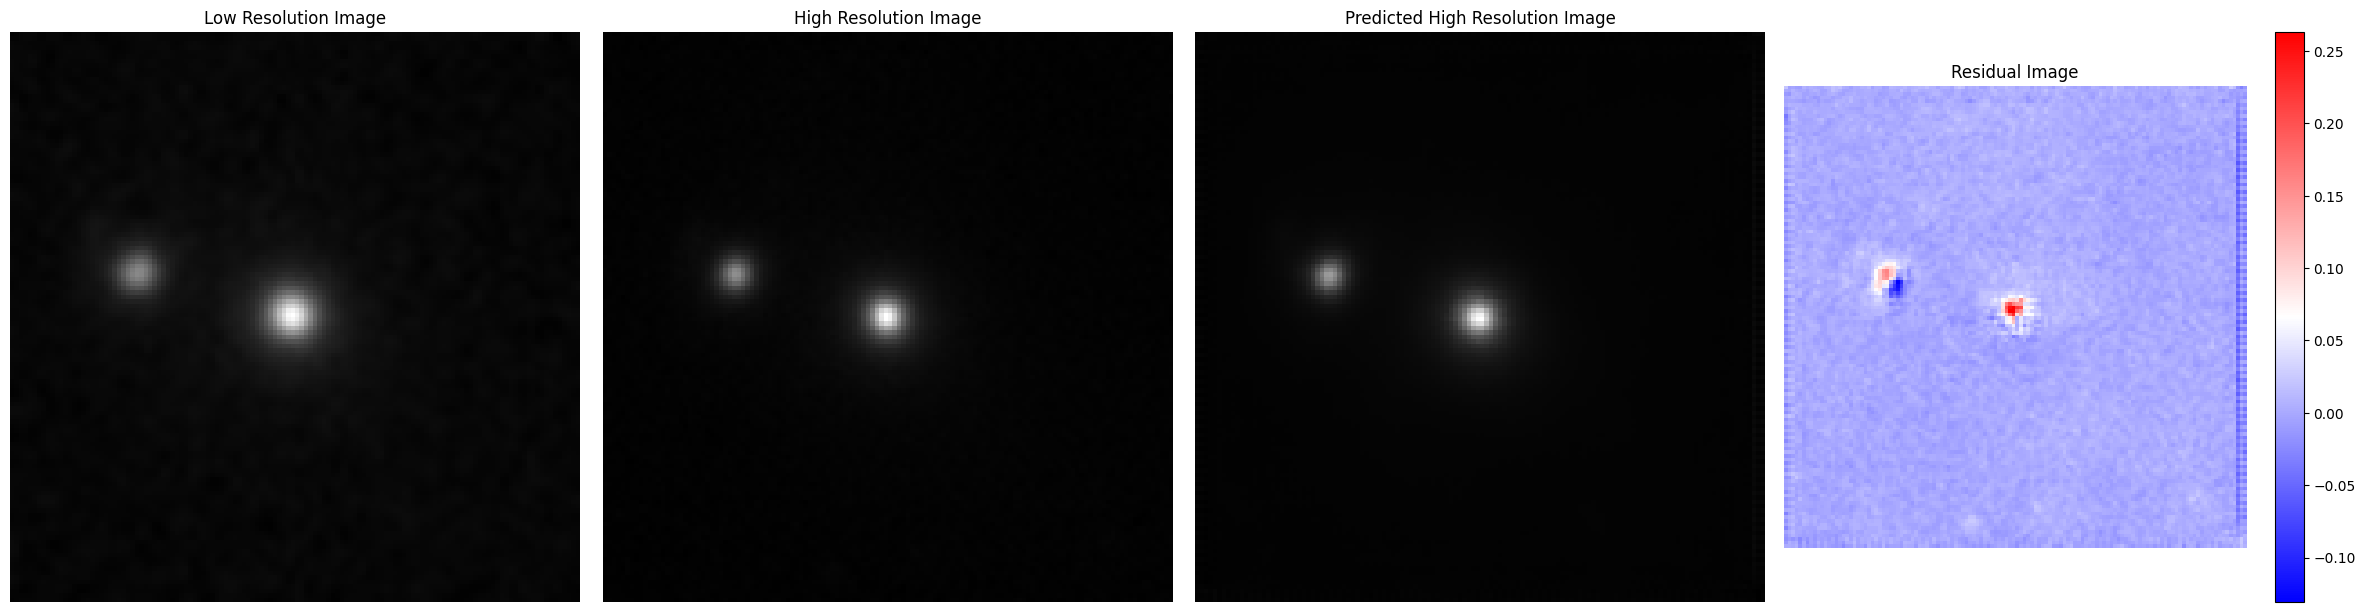

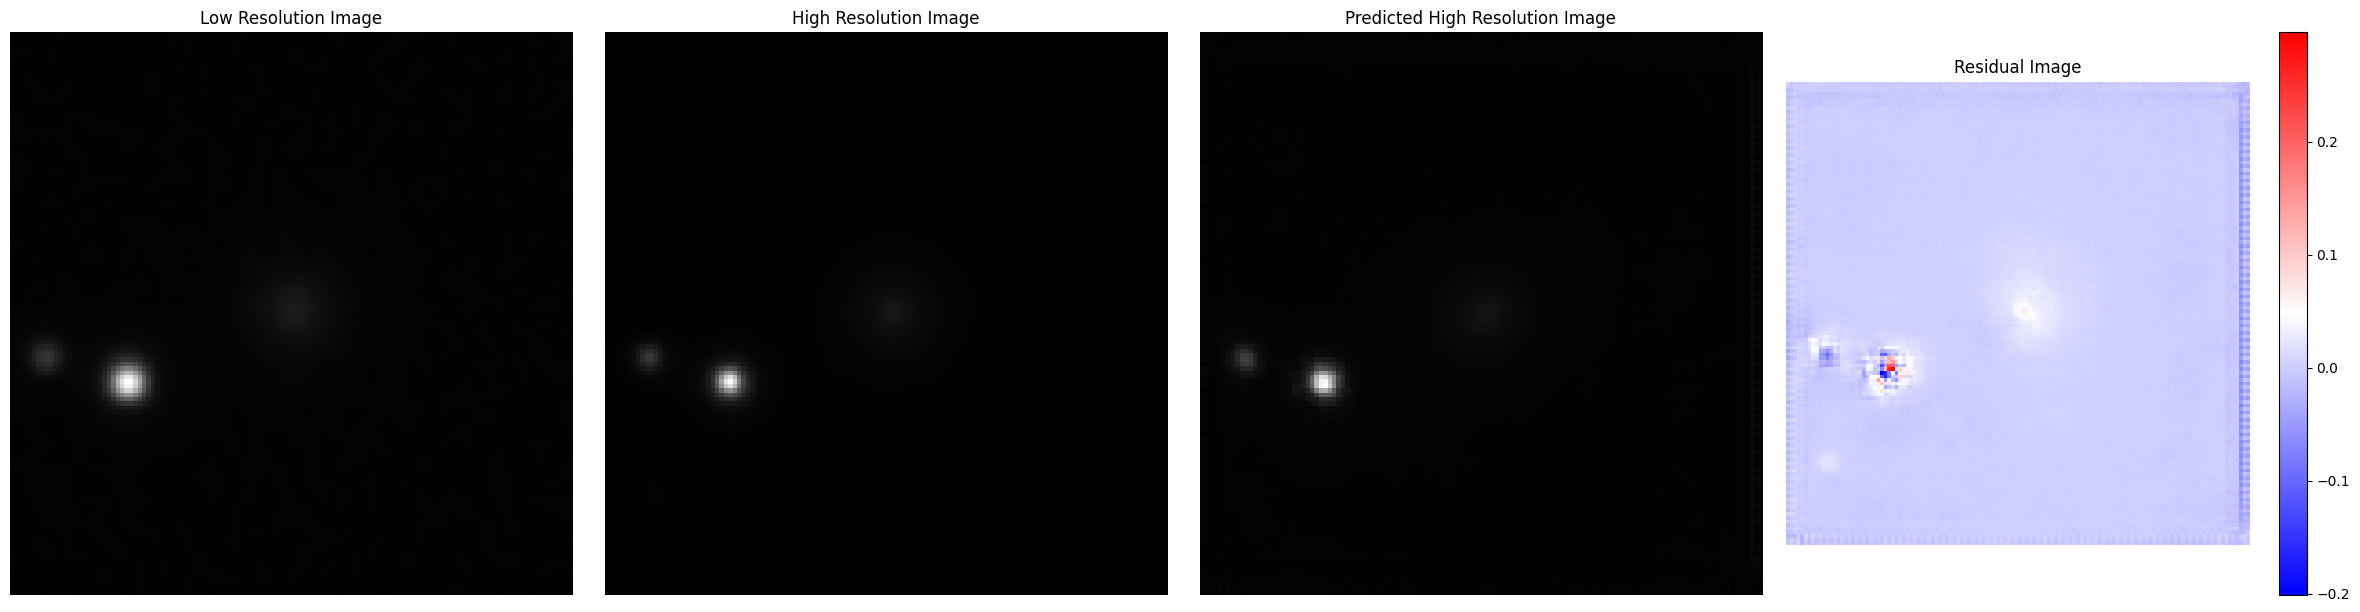

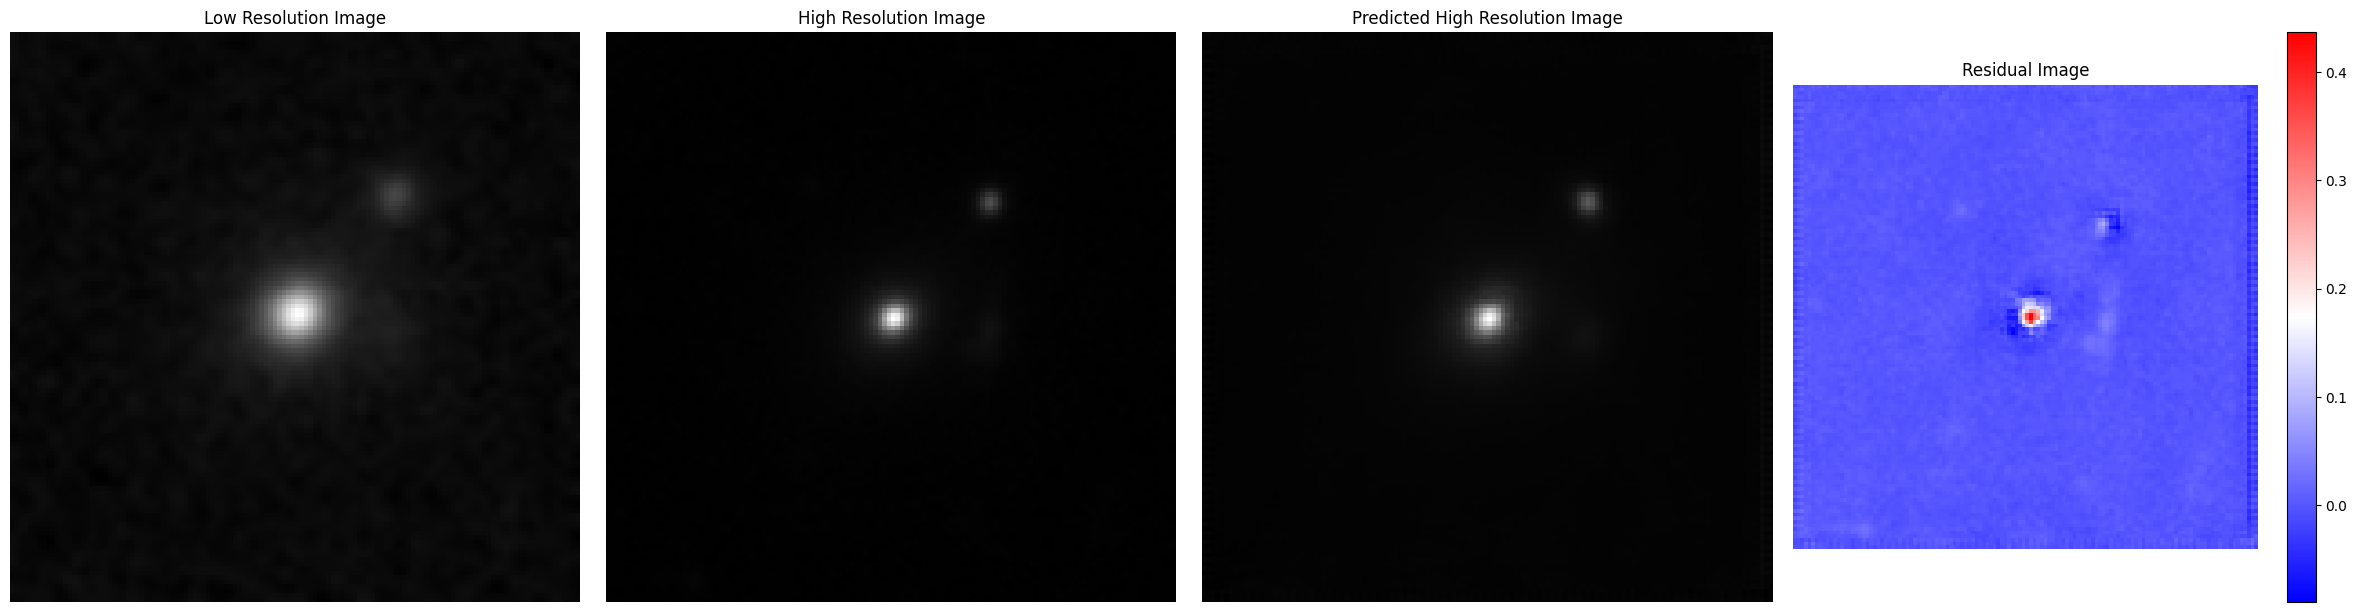

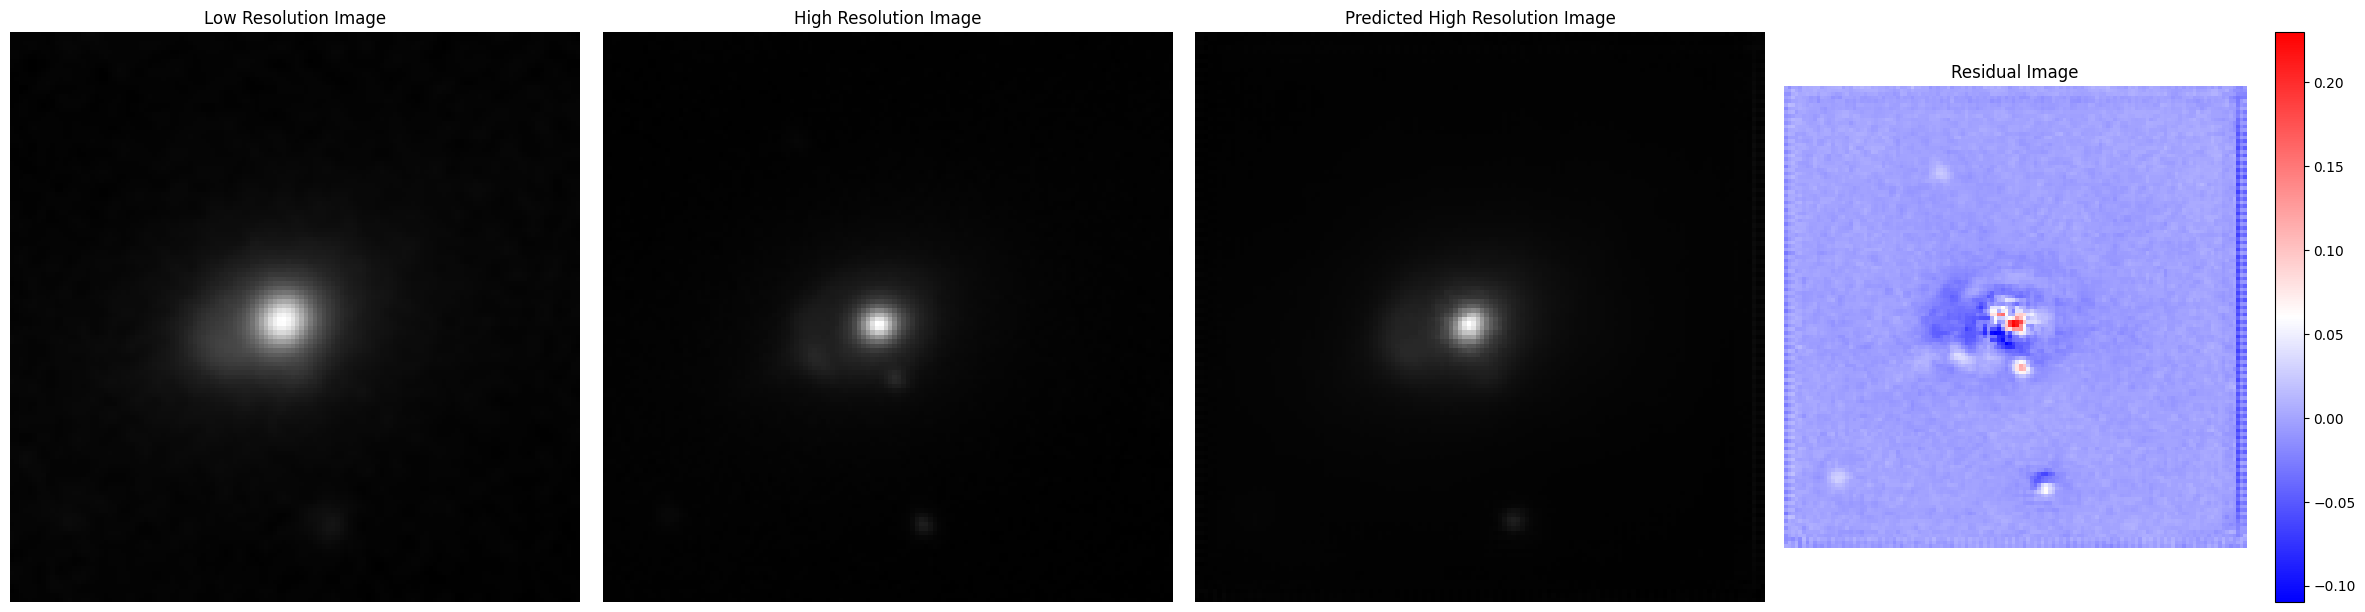

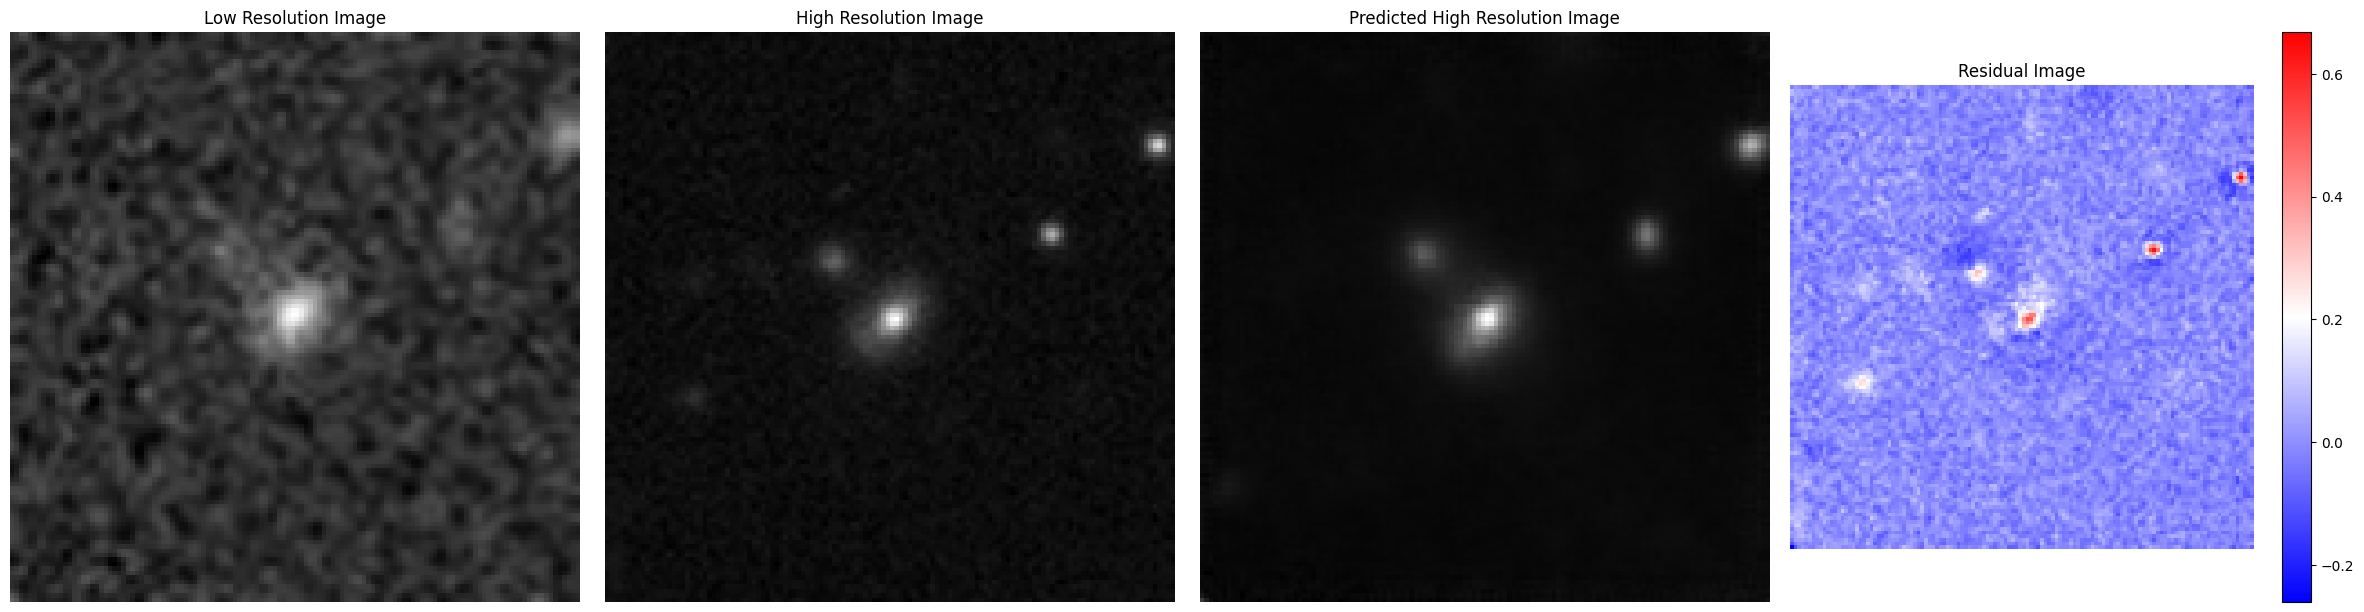

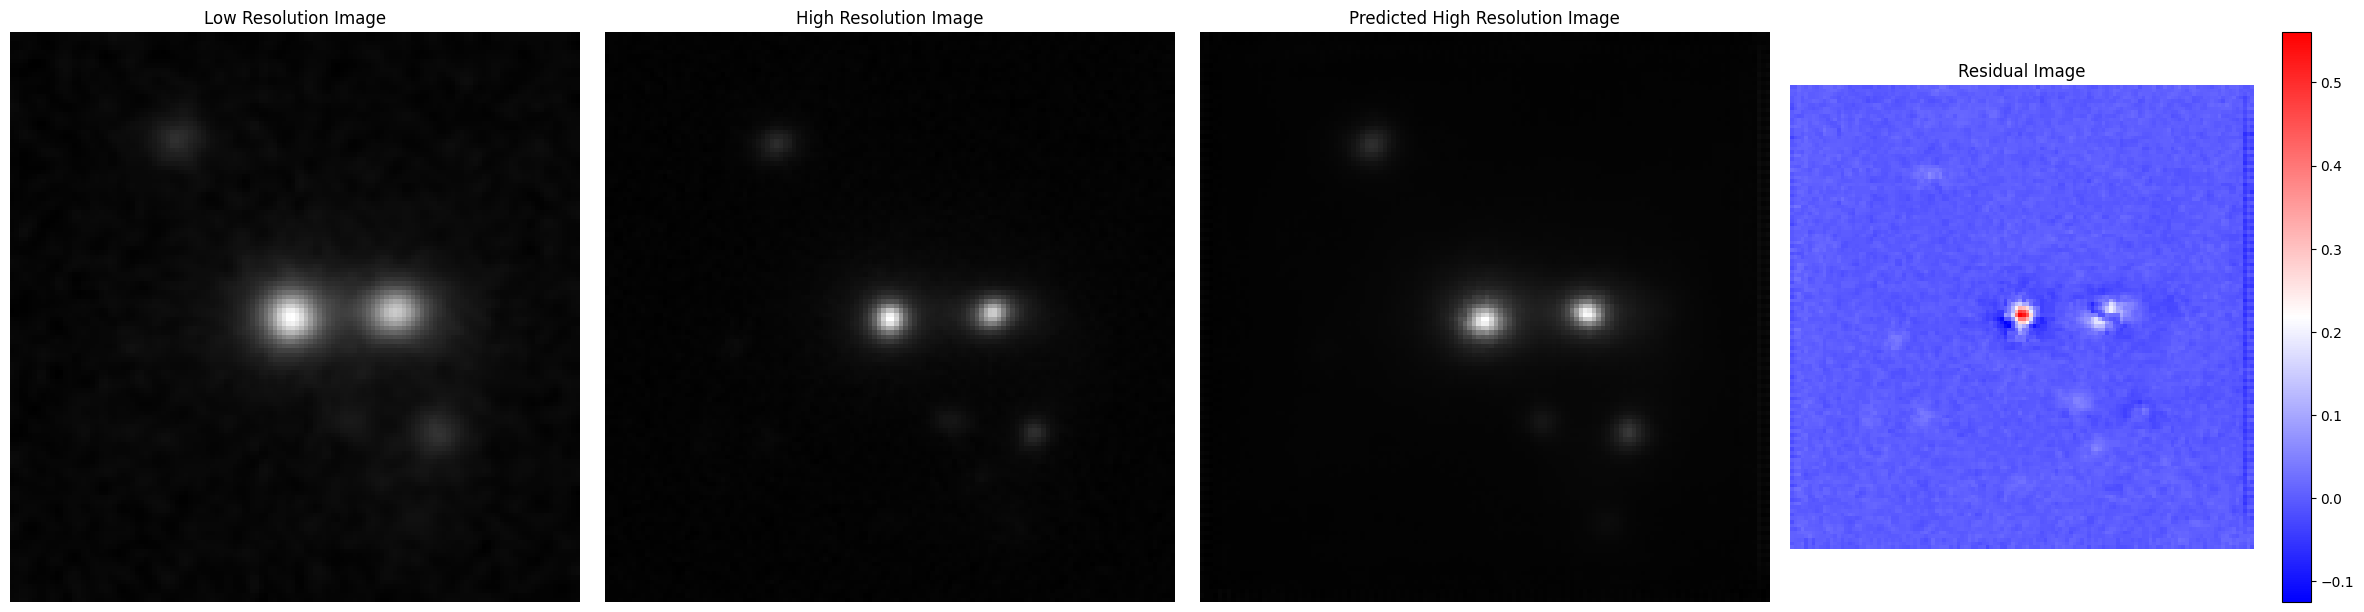

Evaluating:  14%|█▍        | 5/36 [00:27<02:48,  5.43s/it]


In [22]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_diffusion_model(model, test_dataloader, device, num_batches=5):
    model.eval()
    
    with torch.no_grad():
        for i, (lr_batch, hr_batch) in enumerate(tqdm(test_dataloader, desc="Evaluating")):
            if i >= num_batches:
                break
            
            lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
            
            # Set the timestep to 1000 for starting from random noise
            timesteps = torch.full((lr_batch.size(0),), 1000, device=device).long()
            
            # Generate random noisy residual
            random_residual = torch.randn_like(lr_batch)
            
            # Concatenate LR and random residual
            model_input = torch.cat([lr_batch, random_residual], dim=1)
            
            # Get model prediction
            pred_hr_residual = model(model_input, timesteps)
            
            # Generate predicted HR image
            pred_hr_batch = lr_batch + pred_hr_residual
            
            lr_batch = lr_batch.cpu()
            hr_batch = hr_batch.cpu()
            pred_hr_batch = pred_hr_batch.cpu()
            pred_hr_residual = hr_batch-pred_hr_batch
            
            for j in range(lr_batch.size(0)):  
                lr = lr_batch[j].squeeze()
                hr = hr_batch[j].squeeze()
                pred_hr = pred_hr_batch[j].squeeze()
                residual = pred_hr_residual[j].squeeze()
                
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
                
                im1 = ax1.imshow(lr, cmap='gray')
                ax1.set_title('Low Resolution Image')
                ax1.axis('off')
#                 fig.colorbar(im1, ax=ax1)
                
                im2 = ax2.imshow(hr, cmap='gray')
                ax2.set_title('High Resolution Image')
                ax2.axis('off')
#                 fig.colorbar(im2, ax=ax2)
                
                im3 = ax3.imshow(pred_hr, cmap='gray')
                ax3.set_title('Predicted High Resolution Image')
                ax3.axis('off')
#                 fig.colorbar(im3, ax=ax3)
                
                im4 = ax4.imshow(residual, cmap='bwr')
                ax4.set_title('Residual Image')
                ax4.axis('off')
                fig.colorbar(im4, ax=ax4)
                
                plt.tight_layout()
                plt.show()

evaluate_diffusion_model(model, test_loader, device, num_batches=5)